In [2]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

     |████████████████████████████████| 48.5MB 1.0MB/s 


In [3]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
!gsutil ls gs://{gs_path}

gs://platform-ai-research/datasets/ProductNet/crawl-300d-2M.vec
gs://platform-ai-research/datasets/ProductNet/df2_20000
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_5_4
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7_2
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7_3
gs://platform-ai-research/datasets/ProductNet/labels_5m
gs://platform-ai-research/datasets/ProductNet/metadata.feather
gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513
gs://platform-ai-research/datasets/ProductNet/taxonomy-with-ids.en-US.xls
gs://platform-ai-research/datasets/ProductNet/urls_20000
gs://platform-ai-research/datasets/ProductNet//
gs://platform-ai-research/datasets/ProductNet/images/
gs://platform-ai-research/datasets/ProductNet/kn_models/
gs://platform-ai-research/datasets/ProductNet/mapped_label_temp_files/
gs://platform-ai-research/datasets/ProductNet/metadata_t

Run the following only once.

In [4]:
# Pull from GS
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'urls_20000'

remote_file = gs_path + file_name
!gsutil cp gs://{remote_file} {file_name} 

# read from local
url_df = pd.read_feather('urls_20000')

Copying gs://platform-ai-research/datasets/ProductNet/urls_20000...
- [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      


In [0]:
# Next step is to download the images
if (not os.path.exists('./images_folder/')):
    !mkdir 'images_folder'

from tqdm import tqdm

# imUrls = url_df.imUrl.tolist()
# asins = url_df.asin.tolist()

In [6]:
# Pull from GS
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'df2_20000'

remote_file = gs_path + file_name
!gsutil cp gs://{remote_file} {file_name} 

df2 = pd.read_feather('df2_20000')

Copying gs://platform-ai-research/datasets/ProductNet/df2_20000...
/ [1 files][691.6 KiB/691.6 KiB]                                                
Operation completed over 1 objects/691.6 KiB.                                    


In [19]:
select = ['Shoes', 'Clothing', 'Personal Care',
          'Backpacks', 'Vehicle Parts & Accessories',
          'Toys', 'Sofas', 'Puzzles',
          'Jewelry', 'Lawn & Garden']

select_df = df2[df2['label'].isin(select)]

select_df.head()

,asin,label
19,B001RZ4B7K,Vehicle Parts & Accessories
30,B005TU6MJ4,Sofas
33,B00G0Q0GP2,Clothing
47,B004SZGHGO,Shoes
61,B001KW0BYW,Sofas


In [23]:
len(select_df)

1440

In [21]:
df_label_url = pd.merge(select_df, url_df,
                        left_on='asin', right_on='asin',
                        how='inner')

df_label_url.head()

,asin,label,imUrl
0,B001RZ4B7K,Vehicle Parts & Accessories,http://ecx.images-amazon.com/images/I/31NwFq-T...
1,B005TU6MJ4,Sofas,http://ecx.images-amazon.com/images/I/510HRpu1...
2,B00G0Q0GP2,Clothing,http://ecx.images-amazon.com/images/I/41TZSOrm...
3,B004SZGHGO,Shoes,http://ecx.images-amazon.com/images/I/31sdKgz0...
4,B001KW0BYW,Sofas,http://ecx.images-amazon.com/images/I/41va%2Bn...


In [0]:
imUrls = df_label_url.imUrl.tolist()
labels = df_label_url.label.tolist()
asins = df_label_url.asin.tolist()

In [49]:
os.getcwd()

'/content/images_folder'

In [41]:
select

['Shoes',
 'Clothing',
 'Personal Care',
 'Backpacks',
 'Vehicle Parts & Accessories',
 'Toys',
 'Sofas',
 'Puzzles',
 'Jewelry',
 'Lawn & Garden']

In [42]:
!mkdir Shoes
!mkdir Clothing
!mkdir Personal Care
!mkdir Backpacks
!mkdir Vehicle Parts & Accessories
!mkdir Toys
!mkdir Sofas
!mkdir Puzzles
!mkdir Jewelry
!mkdir Lawn & Garden

/bin/bash: Accessories: command not found
/bin/bash: Garden: command not found


In [51]:
%%time
for url_label_id in tqdm(zip(imUrls, labels, asins)):
    url = url_label_id[0] # url of image
    label = url_label_id[1].split(' ')[0] # label
    asin = url_label_id[2] # asin of image
    
    filename = label + '/' + asin + '.jpg'    
    
    print(filename)       
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            select_df = select_df[select_df.asin != asin]           # if missing, remove from dataset
            with open("./missing_select_df.txt", "a") as f:
                f.write(asin+'\n')                

0it [00:00, ?it/s]

Vehicle/B001RZ4B7K.jpg
Sofas/B005TU6MJ4.jpg


2it [00:00,  3.23it/s]

Clothing/B00G0Q0GP2.jpg


3it [00:00,  3.54it/s]

Shoes/B004SZGHGO.jpg


5it [00:01,  4.43it/s]

Sofas/B001KW0BYW.jpg
Jewelry/B000J2ODDY.jpg


6it [00:01,  4.56it/s]

Clothing/B004HEWZ6C.jpg


7it [00:01,  4.59it/s]

Clothing/B001CS69L8.jpg


8it [00:01,  4.64it/s]

Vehicle/B006G4S41Q.jpg


9it [00:02,  4.65it/s]

Personal/B00EPF9LEW.jpg


10it [00:02,  4.31it/s]

Shoes/B001CPK8I6.jpg


11it [00:02,  4.07it/s]

Shoes/B00DIEL856.jpg


12it [00:02,  4.28it/s]

Lawn/B00DOJI59M.jpg


13it [00:03,  3.60it/s]

Vehicle/B00798G3D4.jpg


14it [00:03,  3.89it/s]

Shoes/B007V7MUXU.jpg


15it [00:03,  4.10it/s]

Lawn/B00874ZBYG.jpg


16it [00:03,  3.76it/s]

Lawn/B001BO534C.jpg


17it [00:04,  2.72it/s]

Backpacks/B004I82SA0.jpg


18it [00:04,  3.00it/s]

Sofas/B0011E1ZDA.jpg


19it [00:04,  3.39it/s]

Shoes/B00E90XJ5K.jpg


20it [00:05,  3.70it/s]

Sofas/B000UV0TYG.jpg


21it [00:05,  3.69it/s]

Backpacks/B00823AK4S.jpg


23it [00:06,  3.72it/s]

Lawn/B00CCR3XCQ.jpg
Puzzles/B004PGM91I.jpg


24it [00:06,  3.45it/s]

Puzzles/B00A1S7DEW.jpg


25it [00:06,  3.54it/s]

Vehicle/B000KL559K.jpg


26it [00:06,  3.87it/s]

Vehicle/B004I16OJS.jpg


27it [00:07,  3.81it/s]

Backpacks/B006H935FK.jpg


29it [00:07,  4.60it/s]

Vehicle/B00319P0TI.jpg
Toys/B004M7283O.jpg


31it [00:07,  5.13it/s]

Personal/B0074FVYV8.jpg
Toys/B000SO7B1E.jpg


32it [00:08,  5.00it/s]

Puzzles/B0061LTQOI.jpg


34it [00:08,  5.09it/s]

Personal/B003156GG8.jpg
Shoes/B009JXR2JG.jpg


36it [00:08,  4.73it/s]

Personal/B0062N5AZO.jpg
Vehicle/B000Z10LPS.jpg


37it [00:09,  5.39it/s]

Toys/B0007Y13MI.jpg


39it [00:09,  5.92it/s]

Personal/B0019LWKVQ.jpg
Shoes/B0061IPMFI.jpg


40it [00:09,  4.48it/s]

Puzzles/B000MF95LS.jpg


41it [00:10,  3.47it/s]

Personal/B00162UYBQ.jpg


43it [00:10,  4.39it/s]

Lawn/B000W7A5RO.jpg
Jewelry/B0002KK48G.jpg


45it [00:10,  5.83it/s]

Lawn/B00EJQWX4C.jpg
Sofas/B00ACALZ2A.jpg


47it [00:11,  6.99it/s]

Personal/B008S7UPN4.jpg
Shoes/B005DD2HRI.jpg


49it [00:11,  6.69it/s]

Personal/B001BNZ61I.jpg
Toys/B00DHNSKNG.jpg


50it [00:11,  5.11it/s]

Clothing/B00EXWTU2U.jpg


53it [00:12,  6.17it/s]

Lawn/B00938VR1G.jpg
Jewelry/B008NUNAN8.jpg
Personal/B00367PLYE.jpg


55it [00:12,  7.18it/s]

Personal/B00DDNNP8U.jpg
Backpacks/B009UEVMEK.jpg


56it [00:12,  6.70it/s]

Lawn/B000PD9FOE.jpg


58it [00:12,  5.65it/s]

Toys/B0050Q3PH4.jpg
Vehicle/B001EOYK0W.jpg

59it [00:12,  6.21it/s]


Sofas/B005VY9A1A.jpg


60it [00:13,  5.70it/s]

Backpacks/B00F7360W2.jpg


61it [00:13,  4.77it/s]

Jewelry/B0042PEI84.jpg


62it [00:13,  4.80it/s]

Shoes/B00EJPK1L0.jpg


63it [00:13,  4.84it/s]

Personal/B002JINOOA.jpg


64it [00:14,  4.48it/s]

Shoes/B0043515UM.jpg


65it [00:14,  4.15it/s]

Vehicle/B004KG3HU0.jpg


67it [00:14,  4.12it/s]

Vehicle/B0015AT7RQ.jpg
Personal/B0074O2OI6.jpg


69it [00:15,  5.17it/s]

Personal/B007HDSHXK.jpg
Clothing/B00B5F5N1K.jpg


70it [00:15,  4.71it/s]

Toys/B003KYHKME.jpg


71it [00:15,  3.92it/s]

Personal/B001TK3GHE.jpg


72it [00:16,  3.88it/s]

Toys/B0050EQ5R8.jpg


73it [00:16,  3.77it/s]

Shoes/B00B9TYCZU.jpg


74it [00:16,  3.65it/s]

Clothing/B00E84CFR0.jpg


76it [00:17,  3.72it/s]

Puzzles/B00147VX5Y.jpg
Lawn/B00DO0SRSA.jpg


77it [00:17,  3.99it/s]

Clothing/B005NPM2Y4.jpg


80it [00:17,  4.93it/s]

Shoes/B005MQLE9S.jpg
Jewelry/B003XH4WRE.jpg
Shoes/B00ED2PZCE.jpg


82it [00:18,  5.21it/s]

Toys/B000N16VG8.jpg
Jewelry/B00HIV6T86.jpg


83it [00:18,  5.90it/s]

Toys/B000A7W45W.jpg


84it [00:18,  5.54it/s]

Personal/B001ASZT3E.jpg


85it [00:18,  4.83it/s]

Puzzles/B004E36EBI.jpg


86it [00:19,  3.84it/s]

Shoes/B00CJLAAA8.jpg


87it [00:19,  3.45it/s]

Puzzles/B009AEXNO2.jpg


88it [00:20,  3.13it/s]

Toys/B001AXVSA2.jpg


89it [00:20,  3.50it/s]

Shoes/B000YBCJQI.jpg


90it [00:20,  3.32it/s]

Clothing/B009LTN7SS.jpg


92it [00:21,  3.81it/s]

Toys/B0053YL3HC.jpg
Vehicle/B001GFFXI2.jpg


94it [00:21,  4.99it/s]

Backpacks/B004EBREUK.jpg
Personal/B002JINO68.jpg


96it [00:21,  4.57it/s]

Jewelry/B0093X8DL8.jpg
Clothing/B00GXPC5TU.jpg


97it [00:22,  4.25it/s]

Jewelry/B006F64S7Y.jpg


98it [00:22,  3.95it/s]

Puzzles/B00F2H6R80.jpg


99it [00:22,  3.77it/s]

Sofas/B00CHR6LLG.jpg


101it [00:23,  4.48it/s]

Vehicle/B007PRYUAW.jpg
Personal/B00163DCVE.jpg


102it [00:23,  4.57it/s]

Backpacks/B002YNW1BM.jpg


103it [00:23,  3.96it/s]

Clothing/B00HVS98U2.jpg


104it [00:23,  3.77it/s]

Backpacks/B0019LHGVU.jpg


105it [00:24,  3.83it/s]

Lawn/B00E0CUPAE.jpg


106it [00:24,  4.05it/s]

Sofas/B001E4IM3I.jpg


107it [00:24,  3.98it/s]

Puzzles/B0060L2Z9M.jpg


109it [00:25,  4.00it/s]

Vehicle/B0079M9CHO.jpg
Toys/B00ABEP654.jpg


111it [00:25,  4.66it/s]

Vehicle/B005I3XT5W.jpg
Toys/B001K6XI16.jpg


112it [00:25,  4.20it/s]

Vehicle/B00ISBQR8M.jpg


114it [00:26,  4.81it/s]

Sofas/B006LAK9A4.jpg
Clothing/B00CF1SX8S.jpg


115it [00:26,  4.78it/s]

Personal/B002FCN7VU.jpg


116it [00:26,  4.25it/s]

Backpacks/B00380XN08.jpg


117it [00:27,  3.92it/s]

Toys/B004DTQOFO.jpg


118it [00:27,  4.18it/s]

Shoes/B00AMTDP7Y.jpg


120it [00:27,  3.94it/s]

Shoes/B00ETCLPKY.jpg
Backpacks/B00G6KU67K.jpg


121it [00:28,  3.58it/s]

Toys/B007CLZPRI.jpg


122it [00:28,  2.97it/s]

Backpacks/B005IQGN3O.jpg


123it [00:28,  3.35it/s]

Vehicle/B000FC37PS.jpg


124it [00:29,  3.37it/s]

Vehicle/B000KYX3ZU.jpg


125it [00:29,  2.48it/s]

Lawn/B005FW5ABW.jpg


127it [00:30,  3.42it/s]

Jewelry/B00A183JCW.jpg
Shoes/B00ETADMEI.jpg


128it [00:30,  4.18it/s]

Jewelry/B004RA035Q.jpg


129it [00:30,  4.35it/s]

Shoes/B00EN6NSII.jpg


131it [00:30,  4.80it/s]

Sofas/B003BYQ12I.jpg
Toys/B00GXZVHA8.jpg


132it [00:31,  4.22it/s]

Shoes/B006MQ1B4K.jpg


133it [00:31,  4.08it/s]

Toys/B0009NS15E.jpg


134it [00:31,  3.67it/s]

Jewelry/B009N8XSJU.jpg


135it [00:32,  3.69it/s]

Puzzles/B00466IF1K.jpg


136it [00:32,  3.96it/s]

Backpacks/B00JX8HIF0.jpg


137it [00:32,  4.17it/s]

Shoes/B0025KUGVG.jpg


138it [00:32,  4.16it/s]

Lawn/B000LO027Q.jpg


139it [00:32,  4.33it/s]

Vehicle/B001GG8EA0.jpg


140it [00:33,  4.47it/s]

Puzzles/B00BK7LT66.jpg
Backpacks/B009R6B6IS.jpg


142it [00:33,  5.26it/s]

Jewelry/B00DAUBDEO.jpg


144it [00:33,  5.84it/s]

Jewelry/B0029T74CW.jpg
Backpacks/B001U6MJCK.jpg


145it [00:33,  5.36it/s]

Lawn/B00FOD1E0S.jpg


146it [00:34,  4.75it/s]

Vehicle/B001PYGD60.jpg


147it [00:34,  4.43it/s]

Lawn/B00ILV7EZO.jpg


149it [00:34,  5.24it/s]

Sofas/B006IUBFQO.jpg
Backpacks/B008RB3CUE.jpg


152it [00:35,  6.79it/s]

Toys/B00001ZUKL.jpg
Sofas/B005JFP9JS.jpg
Lawn/B004EG8PIA.jpg


154it [00:35,  6.61it/s]

Vehicle/B002VUDQP8.jpg
Vehicle/B000CB0SWM.jpg


155it [00:35,  7.00it/s]

Jewelry/B0097IYKG6.jpg


156it [00:35,  6.21it/s]

Toys/B00IAPQLEG.jpg


157it [00:36,  4.93it/s]

Lawn/B005UJ2XJC.jpg


158it [00:36,  3.55it/s]

Clothing/B008BSOHTS.jpg


159it [00:36,  3.66it/s]

Shoes/B0090QZQP4.jpg


160it [00:36,  3.94it/s]

Shoes/B007388DC4.jpg


161it [00:37,  4.19it/s]

Toys/B0034KZDUU.jpg


162it [00:37,  4.35it/s]

Sofas/B002AHX4PY.jpg


164it [00:37,  4.27it/s]

Sofas/B00CUMROVY.jpg
Vehicle/B00H88F0AM.jpg


165it [00:38,  4.41it/s]

Personal/B002JINOS6.jpg


166it [00:38,  4.06it/s]

Vehicle/B008TSYTAW.jpg


167it [00:38,  3.97it/s]

Puzzles/B006YQKQF8.jpg


168it [00:39,  3.16it/s]

Backpacks/B004Q5G9WS.jpg


170it [00:39,  3.95it/s]

Sofas/B00CHHDI26.jpg
Lawn/B00DX5LCEM.jpg


171it [00:39,  3.89it/s]

Backpacks/B0034KW5PG.jpg


173it [00:40,  3.86it/s]

Jewelry/B005OBNSYK.jpg
Vehicle/B00BT1GR56.jpg


175it [00:40,  4.76it/s]

Jewelry/B00DBCMFN4.jpg
Personal/B00K1KDRG8.jpg


176it [00:40,  4.24it/s]

Shoes/B00E14X5RQ.jpg


177it [00:41,  4.38it/s]

Lawn/B003VRRZZC.jpg


178it [00:41,  4.52it/s]

Clothing/B00DBRXCR2.jpg


180it [00:41,  4.81it/s]

Sofas/B00HK60OXK.jpg
Lawn/B000HMCDGU.jpg


183it [00:42,  5.95it/s]

Personal/B000LTP9Q0.jpg
Clothing/B00GHPXOUK.jpg
Vehicle/B000JHVRHO.jpg


184it [00:42,  6.57it/s]

Puzzles/B007MHE9II.jpg


186it [00:42,  4.55it/s]

Puzzles/B006IKVH7G.jpg
Puzzles/B00E6AA15O.jpg


187it [00:43,  3.69it/s]

Lawn/B000JEED8C.jpg
Toys/B00006653G.jpg


190it [00:43,  4.58it/s]

Clothing/B001TOLM76.jpg
Vehicle/B004GCK9N6.jpg
Jewelry/B002NCMFFG.jpg


193it [00:44,  5.92it/s]

Backpacks/B00A451SJ8.jpg
Puzzles/B007SVR0T8.jpg


194it [00:44,  6.42it/s]

Sofas/B005QGZ9YU.jpg


195it [00:44,  5.71it/s]

Personal/B002LZUMZK.jpg


197it [00:45,  4.72it/s]

Jewelry/B0050CVJCG.jpg
Sofas/B003D7LD5I.jpg


198it [00:45,  5.42it/s]

Jewelry/B00CRDNM9Y.jpg


199it [00:45,  4.97it/s]

Shoes/B00GZYK1MM.jpg


200it [00:45,  4.37it/s]

Clothing/B00CO0N6B4.jpg


202it [00:46,  4.46it/s]

Jewelry/B006812GJS.jpg
Backpacks/B002UGQECU.jpg


203it [00:46,  4.56it/s]

Clothing/B00AAF5CK8.jpg


204it [00:46,  4.63it/s]

Personal/B008N93UPC.jpg


206it [00:47,  4.31it/s]

Backpacks/B000H82562.jpg
Puzzles/B004TV1WDU.jpg


207it [00:47,  3.99it/s]

Clothing/B006URGT5C.jpg


208it [00:47,  3.95it/s]

Jewelry/B0065SOLZG.jpg


209it [00:48,  3.49it/s]

Puzzles/B006FBVGT2.jpg


210it [00:48,  3.32it/s]

Puzzles/B004BA7HYC.jpg


212it [00:48,  4.02it/s]

Backpacks/B0033W9DZK.jpg
Lawn/B001VGC0DM.jpg


214it [00:49,  4.56it/s]

Backpacks/B006TO5UBK.jpg
Vehicle/B004BRAHQA.jpg


216it [00:49,  5.61it/s]

Vehicle/B002OEBKFE.jpg
Puzzles/B0006NDBD4.jpg


217it [00:49,  4.34it/s]

Clothing/B009YSUWNE.jpg


218it [00:50,  4.49it/s]

Clothing/B00GSW6M6A.jpg


219it [00:50,  4.05it/s]

Puzzles/B00HZ5FXTQ.jpg


221it [00:50,  4.54it/s]

Lawn/B006MIYLAY.jpg
Personal/B002CML1FC.jpg


222it [00:51,  4.56it/s]

Jewelry/B0072ZF9DY.jpg


224it [00:51,  4.85it/s]

Shoes/B00G4EZBYQ.jpg
Puzzles/B001OVV69I.jpg


225it [00:51,  4.46it/s]

Shoes/B000B88KYO.jpg


227it [00:52,  5.05it/s]

Sofas/B00CMBK1TA.jpg
Sofas/B009N1IE96.jpg


228it [00:52,  5.27it/s]

Shoes/B00888KJJS.jpg


229it [00:52,  4.20it/s]

Personal/B0034Q1MIG.jpg


230it [00:52,  3.73it/s]

Clothing/B00H7ZGDCU.jpg


231it [00:53,  3.82it/s]

Backpacks/B0054P0WPE.jpg


232it [00:53,  3.83it/s]

Jewelry/B000LVXWAS.jpg


233it [00:53,  4.09it/s]

Clothing/B005DMXZVQ.jpg


234it [00:53,  4.28it/s]

Toys/B000068NS1.jpg


235it [00:54,  4.44it/s]

Vehicle/B0006ZRG4C.jpg
Personal/B000AS7EW4.jpg


239it [00:54,  6.05it/s]

Shoes/B008LRBOOU.jpg
Personal/B001GKNSNO.jpg
Shoes/B007QYT8KG.jpg


240it [00:54,  3.93it/s]

Personal/B00B3PBFK0.jpg


241it [00:55,  3.94it/s]

Sofas/B0054WS1KK.jpg


242it [00:55,  4.19it/s]

Toys/B007KMW9SM.jpg


243it [00:55,  4.33it/s]

Sofas/B00D8L04P4.jpg


244it [00:56,  3.61it/s]

Jewelry/B005ZWXEX8.jpg


245it [00:56,  3.74it/s]

Shoes/B007VC50ZA.jpg


247it [00:56,  4.45it/s]

Shoes/B00144LXN4.jpg
Lawn/B00DGACY3W.jpg


248it [00:57,  3.18it/s]

Puzzles/B004NVZJ6M.jpg


250it [00:57,  3.48it/s]

Sofas/B0069F4RRC.jpg
Vehicle/B001EWUKBW.jpg


251it [00:57,  3.82it/s]

Backpacks/B00BJ8E3DC.jpg


252it [00:58,  4.09it/s]

Toys/B00BW0RGDG.jpg


253it [00:58,  3.67it/s]

Puzzles/B0030DEB4A.jpg


254it [00:58,  3.70it/s]

Backpacks/B009ES1OK4.jpg


255it [00:59,  3.55it/s]

Puzzles/B004S7HM20.jpg


257it [00:59,  3.57it/s]

Jewelry/B0070YNA42.jpg
Shoes/B001HSI9MK.jpg


258it [00:59,  3.86it/s]

Clothing/B0093QQJ4S.jpg


259it [01:00,  3.69it/s]

Shoes/B00DJIPJM4.jpg


260it [01:00,  2.99it/s]

Lawn/B00BL1GB4Q.jpg


262it [01:01,  4.10it/s]

Clothing/B001AN6FTG.jpg
Backpacks/B004H2WN2K.jpg


264it [01:01,  5.54it/s]

Lawn/B005TI9G9O.jpg
Vehicle/B00C7YGGY6.jpg


266it [01:01,  5.27it/s]

Puzzles/B00486R03C.jpg
Personal/B002JINOAE.jpg


267it [01:01,  5.89it/s]

Puzzles/B004A4SBEO.jpg


268it [01:02,  4.79it/s]

Jewelry/B001JKEXDK.jpg


269it [01:02,  4.75it/s]

Jewelry/B0092KG34Q.jpg


271it [01:02,  4.90it/s]

Shoes/B007CB8W0U.jpg
Personal/B002G8F1NK.jpg


273it [01:03,  5.52it/s]

Sofas/B0043RA34O.jpg
Puzzles/B0094R87GY.jpg


274it [01:03,  3.72it/s]

Shoes/B004HGU76A.jpg


275it [01:03,  3.44it/s]

Lawn/B008V45DZE.jpg


276it [01:04,  3.27it/s]

Vehicle/B001S44GUW.jpg


277it [01:04,  3.62it/s]

Jewelry/B00B2D8J4I.jpg


279it [01:04,  3.72it/s]

Personal/B000V3UTWA.jpg
Personal/B000VL20HY.jpg


280it [01:05,  4.45it/s]

Sofas/B008MHG7D2.jpg


281it [01:05,  4.06it/s]

Clothing/B00841HJHE.jpg


282it [01:05,  3.61it/s]

Lawn/B002LQMT4Q.jpg


284it [01:06,  4.43it/s]

Vehicle/B005MRSTWW.jpg
Sofas/B004LQ1R92.jpg


285it [01:06,  4.71it/s]

Puzzles/B00ARSE0D8.jpg


286it [01:06,  4.37it/s]

Sofas/B00CYC6ZBU.jpg


287it [01:06,  4.19it/s]

Lawn/B000ZOPXPS.jpg


288it [01:07,  4.12it/s]

Jewelry/B002MVJ75E.jpg


289it [01:07,  4.29it/s]

Toys/B005N50FVQ.jpg


290it [01:07,  4.22it/s]

Personal/B0074FVZBC.jpg


291it [01:07,  3.96it/s]

Jewelry/B00IIXVLQI.jpg


292it [01:08,  4.13it/s]

Lawn/B00029UIGA.jpg


293it [01:08,  4.30it/s]

Shoes/B00HJ0X9VG.jpg


294it [01:08,  3.96it/s]

Backpacks/B004QMJHY8.jpg


295it [01:08,  4.16it/s]

Puzzles/B000MRIS46.jpg


297it [01:09,  5.06it/s]

Backpacks/B0025TLEZ4.jpg
Shoes/B000S5K2R8.jpg


298it [01:09,  3.49it/s]

Vehicle/B003KCCV16.jpg


300it [01:09,  4.54it/s]

Sofas/B00DGAZSIK.jpg
Puzzles/B00BQYR0OI.jpg


301it [01:10,  4.13it/s]

Vehicle/B00BMW9JDO.jpg


302it [01:10,  4.29it/s]

Vehicle/B003VAS30K.jpg


304it [01:10,  4.78it/s]

Vehicle/B001AWC9D8.jpg
Backpacks/B0066EVFOO.jpg


305it [01:11,  3.82it/s]

Shoes/B00BPWA20A.jpg


306it [01:11,  4.03it/s]

Lawn/B00062ZOL2.jpg


307it [01:11,  3.43it/s]

Lawn/B00CJIAGY6.jpg


308it [01:12,  3.40it/s]

Clothing/B007P298R2.jpg


309it [01:12,  3.50it/s]

Toys/B000M9IFOM.jpg


311it [01:12,  4.18it/s]

Vehicle/B005FXYPQC.jpg
Jewelry/B00E3P1KWU.jpg


312it [01:13,  3.90it/s]

Shoes/B00F8HHCVA.jpg


314it [01:13,  4.76it/s]

Sofas/B005PX8BS0.jpg
Shoes/B000SKUE1C.jpg


315it [01:13,  4.76it/s]

Shoes/B00FABWEWG.jpg


317it [01:14,  4.50it/s]

Backpacks/B003ZDCRRS.jpg
Jewelry/B00361FGZO.jpg


318it [01:14,  5.21it/s]

Lawn/B0006HD97S.jpg


320it [01:14,  3.81it/s]

Vehicle/B00B1EH85E.jpg
Lawn/B00A6D059W.jpg


321it [01:15,  4.57it/s]

Vehicle/B000C2UD4Y.jpg


323it [01:15,  5.24it/s]

Personal/B000UWAWQU.jpg
Jewelry/B007G5RIN4.jpg


324it [01:15,  4.71it/s]

Puzzles/B006O6CMFK.jpg


325it [01:16,  4.20it/s]

Clothing/B003O2DT9A.jpg


326it [01:16,  4.23it/s]

Personal/B002JINN5K.jpg


327it [01:16,  2.85it/s]

Shoes/B001O1WTBW.jpg


328it [01:17,  3.25it/s]

Toys/B000WUAYL8.jpg


330it [01:17,  3.62it/s]

Clothing/B004SQUL60.jpg
Toys/B005M4SWQI.jpg


331it [01:17,  3.48it/s]

Toys/B008OKMNGC.jpg


332it [01:18,  3.26it/s]

Clothing/B005CGXOOG.jpg


333it [01:18,  3.12it/s]

Personal/B003QKS7Q0.jpg


335it [01:19,  3.79it/s]

Clothing/B00C6F1ENO.jpg
Shoes/B005Z5LHPM.jpg


336it [01:19,  3.78it/s]

Personal/B007JBCOTI.jpg


337it [01:19,  4.04it/s]

Vehicle/B005ETQZ9M.jpg


339it [01:19,  4.71it/s]

Shoes/B008QWQV1G.jpg
Shoes/B00DI26JIE.jpg


340it [01:20,  4.13it/s]

Personal/B0009S457M.jpg


341it [01:20,  4.31it/s]

Lawn/B001ZXNDNM.jpg


342it [01:20,  3.59it/s]

Puzzles/B00C6750QE.jpg


343it [01:21,  3.32it/s]

Backpacks/B00FSHG6O4.jpg


344it [01:21,  3.66it/s]

Shoes/B0083I8CHE.jpg


345it [01:21,  3.56it/s]

Shoes/B008AK26OA.jpg


347it [01:22,  4.07it/s]

Jewelry/B00B4RCG14.jpg
Puzzles/B002W7CTSK.jpg


348it [01:22,  4.06it/s]

Toys/B000NH1X8I.jpg


350it [01:22,  4.88it/s]

Shoes/B00HVL0XB2.jpg
Puzzles/B003Q9LOI4.jpg


351it [01:23,  3.67it/s]

Personal/B0031ESPKE.jpg


353it [01:23,  4.20it/s]

Sofas/B007JQ76YQ.jpg
Toys/B0032K1YQ4.jpg


355it [01:23,  4.70it/s]

Clothing/B00C3LW8BI.jpg
Clothing/B004MALR60.jpg


357it [01:24,  5.27it/s]

Puzzles/B0052EL0VW.jpg
Toys/B000WHX6FW.jpg


358it [01:24,  3.31it/s]

Vehicle/B00EDIUQ68.jpg


359it [01:25,  3.63it/s]

Shoes/B00D3NVFOG.jpg
Vehicle/B000CAZM9W.jpg


361it [01:25,  4.38it/s]

Lawn/B000EJ3K2M.jpg


363it [01:25,  4.12it/s]

Jewelry/B00CS5HMLU.jpg
Clothing/B0094KLHS6.jpg


364it [01:26,  3.84it/s]

Clothing/B00AAXYU58.jpg


365it [01:26,  4.07it/s]

Lawn/B007IHJEK0.jpg


366it [01:26,  4.27it/s]

Puzzles/B0013MRRY6.jpg


367it [01:26,  4.41it/s]

Puzzles/B000B5MV7O.jpg


368it [01:27,  3.34it/s]

Lawn/B003AC18OC.jpg


369it [01:27,  3.69it/s]

Vehicle/B007C6ZGMW.jpg


371it [01:27,  4.42it/s]

Vehicle/B001G65016.jpg
Jewelry/B004X75ZZG.jpg


372it [01:28,  4.02it/s]

Personal/B008EIZVOA.jpg


373it [01:28,  4.19it/s]

Toys/B003YCY7DW.jpg


374it [01:28,  4.36it/s]

Lawn/B003VBU172.jpg


375it [01:28,  4.04it/s]

Puzzles/B0002LIEEQ.jpg


376it [01:29,  3.70it/s]

Backpacks/B002B3XOGQ.jpg


377it [01:29,  3.78it/s]

Shoes/B00F3DS5WY.jpg


378it [01:29,  3.33it/s]

Jewelry/B00CQM1GQ2.jpg


380it [01:30,  4.32it/s]

Shoes/B00DMMC0WY.jpg
Lawn/B0002N5AZU.jpg


381it [01:30,  4.95it/s]

Toys/B0081D2K1A.jpg


383it [01:30,  4.63it/s]

Vehicle/B0013REXO8.jpg
Personal/B00A3VO0FM.jpg


384it [01:30,  4.85it/s]

Lawn/B0009XHFQ0.jpg


385it [01:31,  4.54it/s]

Vehicle/B006P180SM.jpg


387it [01:31,  4.80it/s]

Sofas/B0032UOY8E.jpg
Vehicle/B007AE2Y76.jpg


388it [01:31,  3.82it/s]

Backpacks/B007V5BWZ4.jpg


389it [01:32,  4.06it/s]

Jewelry/B00I3IEDOK.jpg


390it [01:32,  3.59it/s]

Backpacks/B004EBN526.jpg


391it [01:32,  3.37it/s]

Shoes/B001RTTDYM.jpg


392it [01:33,  3.27it/s]

Toys/B008AL037G.jpg


394it [01:33,  3.74it/s]

Lawn/B009GJEE9E.jpg
Shoes/B00DCY1XDO.jpg


395it [01:33,  3.84it/s]

Backpacks/B00GP00JQO.jpg


396it [01:34,  3.91it/s]

Shoes/B0020MMQKI.jpg


398it [01:34,  4.57it/s]

Jewelry/B00E0ZQ4NI.jpg
Shoes/B000S5SK2M.jpg


399it [01:34,  4.35it/s]

Vehicle/B004Z2CFXE.jpg


400it [01:35,  4.49it/s]

Puzzles/B00BU0BF12.jpg


401it [01:35,  4.09it/s]

Vehicle/B009E9LY4E.jpg


402it [01:35,  3.76it/s]

Shoes/B009ZLDTHQ.jpg


403it [01:35,  3.65it/s]

Sofas/B001BX6CNE.jpg


405it [01:36,  4.39it/s]

Sofas/B004HVNCRG.jpg
Jewelry/B0082TYY9O.jpg


406it [01:36,  4.05it/s]

Lawn/B007W39P7C.jpg


408it [01:36,  4.80it/s]

Sofas/B00E9BO0MK.jpg
Jewelry/B00FO2M4VC.jpg


409it [01:37,  4.75it/s]

Personal/B005VJN7X2.jpg


410it [01:37,  4.80it/s]

Clothing/B00B9YFQVO.jpg


411it [01:37,  3.63it/s]

Toys/B006LAJDKG.jpg
Toys/B001NH19BI.jpg


413it [01:38,  4.16it/s]

Shoes/B006X4197U.jpg


415it [01:38,  3.86it/s]

Shoes/B00IEZ6AHA.jpg
Jewelry/B006N0LY2O.jpg


416it [01:39,  3.72it/s]

Shoes/B0090OO6KM.jpg


417it [01:39,  3.61it/s]

Personal/B002SFSC2S.jpg


419it [01:39,  4.27it/s]

Sofas/B001IKK902.jpg
Shoes/B00JE3KQTE.jpg


421it [01:40,  5.63it/s]

Personal/B00A48E09A.jpg
Clothing/B00E4Q1XKC.jpg


422it [01:40,  4.97it/s]

Shoes/B005N3WRP0.jpg


423it [01:40,  4.01it/s]

Clothing/B00AQATDEI.jpg


424it [01:40,  4.17it/s]

Backpacks/B00IQHQQW0.jpg


425it [01:41,  4.29it/s]

Vehicle/B003W69NSE.jpg


426it [01:41,  4.35it/s]

Lawn/B005RQQ86M.jpg


427it [01:41,  4.34it/s]

Jewelry/B00C9796UC.jpg


428it [01:41,  4.33it/s]

Lawn/B004I79Y44.jpg


429it [01:42,  3.74it/s]

Personal/B0010MPJY4.jpg


431it [01:42,  4.73it/s]

Personal/B002JINV84.jpg
Clothing/B00GAUUQQM.jpg


432it [01:42,  4.29it/s]

Sofas/B006DAC5O0.jpg


433it [01:42,  4.43it/s]

Vehicle/B0064NSJVE.jpg


434it [01:43,  4.53it/s]

Personal/B007QRA17W.jpg


435it [01:43,  4.29it/s]

Jewelry/B00CQ2QS4M.jpg


436it [01:43,  3.99it/s]

Toys/B002MKQH9Y.jpg


437it [01:44,  3.57it/s]

Shoes/B00AAZ7STG.jpg


438it [01:44,  3.55it/s]

Puzzles/B006ROJO1O.jpg


439it [01:44,  3.84it/s]

Shoes/B00GSDY9D2.jpg


440it [01:44,  3.68it/s]

Clothing/B00GWDB936.jpg


441it [01:45,  2.99it/s]

Toys/B000EPFFY2.jpg


442it [01:45,  3.19it/s]

Toys/B003UT27EK.jpg


443it [01:45,  2.97it/s]

Backpacks/B004ND68NI.jpg


445it [01:46,  4.01it/s]

Jewelry/B00B747B0U.jpg
Clothing/B0092RETJU.jpg


447it [01:46,  4.20it/s]

Sofas/B008OIU3ZW.jpg
Shoes/B00HFYXG8W.jpg


448it [01:47,  4.16it/s]

Puzzles/B00A8PX72U.jpg


450it [01:47,  4.29it/s]

Jewelry/B00FYOVRMM.jpg
Toys/B000JJL9JS.jpg


451it [01:48,  3.02it/s]

Puzzles/B005FYG8PM.jpg


452it [01:48,  2.57it/s]

Clothing/B0053EWMXG.jpg


453it [01:48,  2.99it/s]

Jewelry/B009KL87E6.jpg


454it [01:49,  3.38it/s]

Puzzles/B004V0I1DS.jpg


456it [01:49,  4.17it/s]

Clothing/B007GCILGU.jpg
Vehicle/B00F523XIE.jpg


457it [01:49,  3.91it/s]

Jewelry/B006UM934Q.jpg


458it [01:50,  3.70it/s]

Jewelry/B0046I6N4E.jpg


459it [01:50,  3.96it/s]

Vehicle/B004S98GEG.jpg


460it [01:50,  2.76it/s]

Puzzles/B00HAWW84W.jpg


461it [01:51,  3.16it/s]

Shoes/B007IDEP76.jpg


462it [01:51,  3.32it/s]

Clothing/B00E4Q1XYI.jpg


463it [01:51,  3.65it/s]

Vehicle/B0001MQ7BI.jpg


464it [01:51,  3.91it/s]

Puzzles/B005B8MGFI.jpg


465it [01:52,  3.13it/s]

Sofas/B008UZG8A8.jpg


466it [01:52,  3.20it/s]

Shoes/B00CUMT066.jpg


468it [01:52,  4.15it/s]

Shoes/B00FKI3DXS.jpg
Backpacks/B00CTFL7S8.jpg


469it [01:53,  4.01it/s]

Backpacks/B0054OZ67E.jpg


471it [01:53,  4.96it/s]

Jewelry/B00F65OTHE.jpg
Clothing/B005LQCR4A.jpg


472it [01:53,  4.92it/s]

Lawn/B00AE8W8S0.jpg


473it [01:53,  4.91it/s]

Backpacks/B00I9GV0M4.jpg


475it [01:54,  4.18it/s]

Vehicle/B00DQ6RYGS.jpg
Clothing/B008YX63PQ.jpg


476it [01:54,  4.17it/s]

Toys/B002TAQOQI.jpg


478it [01:55,  3.70it/s]

Shoes/B00EI292KU.jpg
Clothing/B002ZMHDKG.jpg


479it [01:55,  3.26it/s]

Sofas/B00FLY5ZEQ.jpg


480it [01:56,  3.30it/s]

Puzzles/B007EA4H30.jpg


481it [01:56,  3.06it/s]

Backpacks/B004AM63OQ.jpg


482it [01:56,  3.27it/s]

Jewelry/B008TW30X0.jpg


483it [01:57,  3.17it/s]

Vehicle/B004YK4S1O.jpg


484it [01:57,  3.53it/s]

Lawn/B004LSKY08.jpg


485it [01:57,  3.63it/s]

Backpacks/B004G3K4KS.jpg


486it [01:57,  3.92it/s]

Clothing/B00ATCD6XM.jpg


487it [01:58,  3.81it/s]

Clothing/B000VAJ82K.jpg


488it [01:58,  3.64it/s]

Toys/B0009VRQ8O.jpg


489it [01:58,  3.92it/s]

Toys/B009ECHALC.jpg


490it [01:58,  3.93it/s]

Shoes/B003UUM3IO.jpg


492it [01:59,  3.91it/s]

Lawn/B002KIL3Q0.jpg
Sofas/B004D3E4FM.jpg


493it [01:59,  4.66it/s]

Jewelry/B007MS3FYG.jpg


494it [01:59,  4.14it/s]

Clothing/B0056YADX4.jpg


495it [01:59,  4.31it/s]

Clothing/B00BCF22PI.jpg


496it [02:00,  4.39it/s]

Backpacks/B00KWR4CIM.jpg


497it [02:00,  4.43it/s]

Backpacks/B001PO53UM.jpg


499it [02:00,  4.79it/s]

Lawn/B000HHM0BI.jpg
Jewelry/B00CFSQCX4.jpg


501it [02:01,  5.70it/s]

Vehicle/B0053T0B2A.jpg
Sofas/B0017M3UNO.jpg


504it [02:01,  5.63it/s]

Puzzles/B00F15WFZC.jpg
Personal/B00E8SVCXY.jpg
Vehicle/B003OF3YXS.jpg


505it [02:01,  4.85it/s]

Backpacks/B00695698W.jpg


506it [02:02,  4.06it/s]

Clothing/B006GEP1JY.jpg


507it [02:02,  4.24it/s]

Puzzles/B0002HWYN2.jpg


508it [02:02,  3.72it/s]

Vehicle/B0006HO0RQ.jpg


510it [02:03,  4.44it/s]

Vehicle/B006WAVAK6.jpg
Shoes/B00GJKTZZ6.jpg


511it [02:03,  4.76it/s]

Backpacks/B003CHZU5I.jpg


512it [02:03,  4.21it/s]

Puzzles/B0009JMYLU.jpg


514it [02:04,  3.79it/s]

Sofas/B003VH9ROE.jpg
Puzzles/0764959646.jpg


515it [02:04,  3.67it/s]

Sofas/B008SBU1OI.jpg


516it [02:04,  3.93it/s]

Clothing/B0053VN10C.jpg


517it [02:05,  3.72it/s]

Vehicle/B007KPUKIU.jpg


519it [02:05,  4.48it/s]

Vehicle/B0064QE67W.jpg
Puzzles/B006VC593O.jpg


520it [02:05,  4.25it/s]

Puzzles/B0061V017E.jpg


521it [02:06,  3.32it/s]

Shoes/B0002ZYRZC.jpg


522it [02:06,  3.07it/s]

Clothing/B00EE4G0LG.jpg


524it [02:07,  3.91it/s]

Personal/B008M4MYC8.jpg
Vehicle/B007E5NDRQ.jpg


525it [02:07,  4.65it/s]

Shoes/B00FSKZDZ4.jpg


526it [02:07,  4.29it/s]

Puzzles/B009GMKGSY.jpg


527it [02:07,  3.95it/s]

Clothing/B00F5BH45S.jpg


528it [02:07,  3.98it/s]

Jewelry/B008AC09Y2.jpg


529it [02:08,  3.72it/s]

Clothing/B00JEH9H5E.jpg


530it [02:08,  3.58it/s]

Jewelry/B004LULG0S.jpg


531it [02:08,  3.66it/s]

Lawn/B0098MELKG.jpg


533it [02:09,  4.69it/s]

Backpacks/B00FXJXLUO.jpg
Shoes/B00FDZFYVM.jpg


534it [02:09,  3.74it/s]

Clothing/B00E86MRB2.jpg


535it [02:09,  3.31it/s]

Sofas/B001I6JU2O.jpg


536it [02:10,  3.41it/s]

Puzzles/B007FTJUTQ.jpg


537it [02:10,  3.18it/s]

Clothing/B00FSKOW3S.jpg


538it [02:10,  3.52it/s]

Sofas/B003E82LPM.jpg


540it [02:11,  4.44it/s]

Backpacks/B002LL744Q.jpg
Jewelry/B00850WLP4.jpg


542it [02:11,  4.76it/s]

Lawn/B006Y85YMQ.jpg
Clothing/B00AE1I27S.jpg


543it [02:11,  4.20it/s]

Personal/B000KBR28M.jpg


544it [02:12,  3.98it/s]

Shoes/B00EZDNV22.jpg


545it [02:12,  4.11it/s]

Toys/B0081MR4SK.jpg


547it [02:12,  4.84it/s]

Clothing/B0010EDDHW.jpg
Clothing/B0009MZW2A.jpg


549it [02:13,  5.54it/s]

Personal/B003AILV0C.jpg
Toys/B001O8I2FW.jpg


550it [02:13,  4.35it/s]

Clothing/B00DT4Z4PA.jpg


551it [02:13,  4.04it/s]

Clothing/B0041QLZ44.jpg


553it [02:14,  4.74it/s]

Vehicle/B004QEJ6CO.jpg
Lawn/B007TFY83E.jpg


554it [02:14,  4.38it/s]

Clothing/B00AJYFUTI.jpg


555it [02:14,  4.48it/s]

Jewelry/B002TUTTOC.jpg


557it [02:14,  5.16it/s]

Backpacks/B005LUUEG4.jpg
Vehicle/B006RA72TY.jpg


558it [02:15,  4.71it/s]

Toys/B0094J2DZ8.jpg


559it [02:15,  4.75it/s]

Lawn/B005584UJ4.jpg


561it [02:15,  3.91it/s]

Lawn/B00004SQ1N.jpg
Puzzles/B0050MLW3M.jpg


562it [02:16,  4.22it/s]

Jewelry/B005R3ALOK.jpg


563it [02:16,  3.91it/s]

Clothing/B00CTKI8EE.jpg


564it [02:17,  2.93it/s]

Shoes/B00FQWWO0G.jpg


565it [02:17,  3.30it/s]

Clothing/B003M8HN5M.jpg


566it [02:17,  3.42it/s]

Shoes/B0020MML7G.jpg


568it [02:17,  3.99it/s]

Backpacks/B001AHYFR6.jpg
Shoes/B00FI39CQW.jpg


569it [02:18,  4.62it/s]

Vehicle/B004MD5TT8.jpg


570it [02:18,  4.68it/s]

Vehicle/B005NDXZJM.jpg


571it [02:18,  4.14it/s]

Puzzles/B002KFZBM0.jpg


572it [02:18,  3.52it/s]

Lawn/B000T2JA4Q.jpg


573it [02:19,  3.50it/s]

Puzzles/B00G42DVU4.jpg


574it [02:19,  3.81it/s]

Vehicle/B00B6JY6QI.jpg


576it [02:19,  4.57it/s]

Sofas/B005OAX3SC.jpg
Shoes/B00DZI14H2.jpg


578it [02:20,  5.10it/s]

Jewelry/B006OHTI1K.jpg
Vehicle/B000FQ05B8.jpg


579it [02:20,  4.07it/s]

Clothing/B0000728OW.jpg


580it [02:20,  4.22it/s]

Shoes/B00AQLVANO.jpg


581it [02:21,  4.07it/s]

Vehicle/B0023VIN9O.jpg


582it [02:21,  3.27it/s]

Puzzles/B004W9L55Y.jpg


584it [02:21,  3.93it/s]

Personal/B000IVC3Y2.jpg
Puzzles/0764959492.jpg


586it [02:22,  5.05it/s]

Vehicle/B0009WSMRW.jpg
Jewelry/B004ZEZM8W.jpg


587it [02:22,  4.99it/s]

Clothing/B0032DVB1E.jpg


588it [02:22,  4.93it/s]

Jewelry/B006K3DZI0.jpg


589it [02:23,  4.00it/s]

Personal/B002JINJ04.jpg


591it [02:23,  4.15it/s]

Clothing/B0056WPXDG.jpg
Backpacks/B00DJB6I76.jpg


592it [02:23,  4.84it/s]

Lawn/B002UU3MSA.jpg


593it [02:23,  4.07it/s]

Clothing/B00ARAURGK.jpg


594it [02:24,  3.83it/s]

Lawn/B000WMGNDY.jpg


596it [02:24,  4.47it/s]

Vehicle/B006TYTFSE.jpg
Jewelry/B0043EMFN4.jpg


598it [02:25,  5.27it/s]

Personal/B000V4CBKM.jpg
Toys/B00196SXOO.jpg


599it [02:25,  5.13it/s]

Clothing/B00HV37IA4.jpg


600it [02:25,  3.64it/s]

Backpacks/B0042DWSLU.jpg


601it [02:25,  3.93it/s]

Toys/B004T19AZC.jpg


602it [02:26,  3.38it/s]

Jewelry/B00EUYZHMS.jpg


604it [02:26,  4.29it/s]

Sofas/B00980NL4U.jpg
Lawn/B004QJQDAM.jpg


606it [02:26,  5.34it/s]

Jewelry/B00FF8CJGA.jpg
Backpacks/B008I57YO4.jpg


607it [02:27,  5.96it/s]

Puzzles/B001QRK1XM.jpg


608it [02:27,  3.85it/s]

Toys/B003UHGCR0.jpg


609it [02:27,  3.68it/s]

Toys/B002DVRB2Y.jpg


611it [02:28,  4.37it/s]

Lawn/B0030T1K0W.jpg
Vehicle/B005M3A5GE.jpg


612it [02:28,  4.46it/s]

Clothing/B00DNPWJ5I.jpg


613it [02:28,  4.28it/s]

Puzzles/B0009OP2VE.jpg


615it [02:29,  5.11it/s]

Jewelry/B001KDO43K.jpg
Puzzles/B0017XYTGU.jpg


617it [02:29,  5.65it/s]

Lawn/B0000BYDVI.jpg
Personal/B007RV7JTU.jpg


619it [02:29,  6.68it/s]

Lawn/B0045122EM.jpg
Puzzles/B0013J71G8.jpg


620it [02:29,  4.54it/s]

Clothing/B001684PPQ.jpg


622it [02:30,  4.56it/s]

Toys/B000O94QRU.jpg
Shoes/B001HN5KLI.jpg


623it [02:30,  4.07it/s]

Puzzles/B0079VOT64.jpg


624it [02:31,  3.64it/s]

Lawn/B007V2LU8G.jpg


625it [02:31,  3.77it/s]

Sofas/B000GB4EU0.jpg


626it [02:31,  3.62it/s]

Shoes/B00GNGOF56.jpg


627it [02:31,  3.72it/s]

Vehicle/B004JATZP8.jpg


628it [02:32,  3.98it/s]

Clothing/B00DGI4XYC.jpg


629it [02:32,  4.20it/s]

Toys/B000NOZ3XC.jpg


631it [02:32,  5.04it/s]

Clothing/B003Y7U7OK.jpg
Sofas/B00JK4SKMW.jpg


632it [02:32,  4.96it/s]

Toys/B000BP5R1Q.jpg


633it [02:33,  4.43it/s]

Puzzles/B003LR5XJC.jpg


634it [02:33,  2.79it/s]

Shoes/B005ECKQL2.jpg


636it [02:34,  3.61it/s]

Backpacks/B00EI5L1OM.jpg
Vehicle/B003PI6W5Q.jpg


637it [02:34,  4.32it/s]

Vehicle/B005BN46TM.jpg


639it [02:34,  4.52it/s]

Clothing/B00ECSUSDA.jpg
Sofas/B00EPD8R2Q.jpg


641it [02:35,  5.44it/s]

Personal/B002IKP0DW.jpg
Toys/B0016KMBC8.jpg


642it [02:35,  4.40it/s]

Backpacks/B004QMF2YM.jpg


643it [02:35,  4.47it/s]

Lawn/B003AD9A9G.jpg


645it [02:36,  4.01it/s]

Vehicle/B005B2DZJ0.jpg
Toys/B0054YXJVE.jpg


646it [02:36,  4.06it/s]

Toys/B0013KCBM6.jpg


648it [02:36,  4.53it/s]

Personal/B002LZUMZA.jpg
Lawn/B006BL9X50.jpg


650it [02:37,  4.79it/s]

Shoes/B00CHRJ2MQ.jpg
Backpacks/B00BM8ETZQ.jpg


651it [02:37,  4.22it/s]

Backpacks/B0019KGMIE.jpg


653it [02:37,  4.83it/s]

Personal/B008W2YXVU.jpg
Vehicle/B008NGW9UW.jpg


655it [02:38,  4.66it/s]

Shoes/B0046NFHKA.jpg
Shoes/B001AMC0MI.jpg


656it [02:38,  5.33it/s]

Shoes/B00598FI00.jpg


657it [02:38,  4.55it/s]

Puzzles/B007K6CFNM.jpg


659it [02:39,  5.25it/s]

Sofas/B00F3VZSRQ.jpg
Sofas/B0043SLONM.jpg


660it [02:39,  5.08it/s]

Lawn/B007XIX6ZS.jpg


661it [02:39,  3.66it/s]

Jewelry/B006G5JJN2.jpg


663it [02:40,  4.12it/s]

Lawn/B001U5Q512.jpg
Clothing/B008HF7P2Q.jpg


664it [02:40,  4.26it/s]

Backpacks/B001I3P7H4.jpg


666it [02:40,  4.63it/s]

Vehicle/B001ET0Y1G.jpg
Jewelry/B00CYL2JQQ.jpg


667it [02:41,  5.38it/s]

Jewelry/B00CMVC3OG.jpg


669it [02:41,  5.81it/s]

Personal/B008DZD3SA.jpg
Clothing/B008Y6CZ2S.jpg


670it [02:41,  5.43it/s]

Clothing/B005O6Q87O.jpg


672it [02:42,  4.50it/s]

Puzzles/B0052YGCYC.jpg
Backpacks/B005HEVLDY.jpg


673it [02:42,  4.27it/s]

Sofas/B003WGM5NO.jpg


674it [02:42,  3.90it/s]

Backpacks/B001UHNRKM.jpg


675it [02:43,  3.50it/s]

Lawn/B001A36LGS.jpg


676it [02:43,  3.81it/s]

Toys/B00C3B03GK.jpg


677it [02:43,  4.04it/s]

Clothing/B002WE8ZJA.jpg


678it [02:43,  4.24it/s]

Personal/B005VJXLRO.jpg


679it [02:43,  4.34it/s]

Puzzles/B000BXHPQS.jpg


681it [02:44,  4.07it/s]

Jewelry/B00D8JC3R8.jpg
Jewelry/B00F529GBW.jpg


682it [02:44,  4.26it/s]

Shoes/B000YEPT8A.jpg


683it [02:45,  3.68it/s]

Puzzles/B0034GSHWK.jpg


685it [02:45,  4.25it/s]

Sofas/B000KS9T18.jpg
Sofas/B002HF61R2.jpg


687it [02:45,  5.04it/s]

Shoes/B009OS2HD2.jpg
Lawn/B0018OVLAK.jpg


689it [02:46,  4.82it/s]

Personal/B00ARNUILQ.jpg
Backpacks/B001H55LF6.jpg


690it [02:46,  5.51it/s]

Vehicle/B00449TQQ2.jpg


691it [02:46,  4.58it/s]

Sofas/B003BVJAV0.jpg


692it [02:46,  4.40it/s]

Personal/B00FZ21MK0.jpg


693it [02:47,  4.27it/s]

Lawn/B00AFFCTRM.jpg


695it [02:47,  4.86it/s]

Sofas/B0016G5VDS.jpg
Personal/B009P44RHE.jpg


697it [02:47,  5.80it/s]

Jewelry/B007SPAHXU.jpg
Vehicle/B00EPYYLPC.jpg


699it [02:48,  4.55it/s]

Vehicle/B00EQHNASW.jpg
Shoes/B0046DKBG0.jpg


701it [02:48,  4.70it/s]

Vehicle/B0076PS946.jpg
Sofas/B00BPJNNGS.jpg


703it [02:49,  5.70it/s]

Toys/B001Q12096.jpg
Vehicle/B003T0CR2M.jpg


704it [02:49,  5.01it/s]

Backpacks/B0007QCRU8.jpg


705it [02:49,  4.92it/s]

Shoes/B00AA01RAC.jpg


706it [02:49,  4.20it/s]

Toys/B000ULVNFU.jpg


707it [02:50,  4.37it/s]

Lawn/B00DD5NWOA.jpg


709it [02:50,  4.85it/s]

Lawn/B00213JPBE.jpg
Puzzles/B002Q9ZUBC.jpg


711it [02:50,  4.99it/s]

Jewelry/B00GM6MB58.jpg
Puzzles/B005744JXS.jpg


712it [02:51,  3.90it/s]

Lawn/B0042H87VG.jpg


713it [02:51,  4.11it/s]

Backpacks/B004CXEJWG.jpg


715it [02:51,  5.02it/s]

Sofas/B002IC16Q0.jpg
Toys/B00006IJS7.jpg


716it [02:52,  4.05it/s]

Backpacks/B00E0LGFUE.jpg


718it [02:52,  4.18it/s]

Shoes/B00DCADTKI.jpg
Backpacks/B004VAABZ4.jpg


720it [02:53,  4.87it/s]

Jewelry/B00ADX9HXU.jpg
Vehicle/B005WVRZ0U.jpg


721it [02:53,  4.52it/s]

Puzzles/B0000BYT0Q.jpg


723it [02:53,  4.48it/s]

Personal/B006W8OX8E.jpg
Vehicle/B001CDP71Q.jpg

724it [02:53,  5.17it/s]


Shoes/B000XRYDCG.jpg


725it [02:54,  5.03it/s]

Lawn/B00D5CLX1U.jpg


727it [02:54,  5.18it/s]

Personal/B0000A10MZ.jpg
Clothing/B0084AK5C6.jpg


729it [02:54,  5.71it/s]

Clothing/B005GO7O68.jpg
Personal/B001IWO4HO.jpg


730it [02:55,  6.28it/s]

Shoes/B009SRPQZK.jpg


731it [02:55,  5.22it/s]

Vehicle/B000CPI6KO.jpg


733it [02:55,  5.45it/s]

Puzzles/B00064433K.jpg
Backpacks/B00GDLMPV2.jpg


734it [02:55,  5.09it/s]

Puzzles/B0007KLH8M.jpg


735it [02:56,  4.37it/s]

Shoes/B004X2FXEE.jpg


737it [02:56,  4.62it/s]

Personal/B0012R339K.jpg
Puzzles/B007WFUXNU.jpg


738it [02:56,  5.00it/s]

Shoes/B00CR6JJHU.jpg


739it [02:57,  4.54it/s]

Clothing/B004QB6QGG.jpg


740it [02:57,  4.60it/s]

Jewelry/B000Q8QI3E.jpg


742it [02:57,  4.95it/s]

Vehicle/B000CGVPK6.jpg
Jewelry/B0057PD8U2.jpg


744it [02:58,  5.23it/s]

Sofas/B001QFE6LM.jpg
Jewelry/B00HO05CKC.jpg


745it [02:58,  4.78it/s]

Personal/B001IWO3RU.jpg


746it [02:58,  4.79it/s]

Personal/B003AILU44.jpg


747it [02:58,  4.81it/s]

Jewelry/B00JQ4ESJ0.jpg


749it [02:59,  4.39it/s]

Vehicle/B001EOV3G6.jpg
Lawn/B005616SAY.jpg


750it [02:59,  4.49it/s]

Clothing/B00EVXBQ78.jpg


751it [02:59,  3.46it/s]

Puzzles/B006BJB8Q4.jpg


752it [03:00,  3.16it/s]

Backpacks/B00C3N79I8.jpg


753it [03:00,  2.96it/s]

Backpacks/B008SXB07S.jpg


755it [03:01,  3.89it/s]

Sofas/B000NLJDO0.jpg
Sofas/B004PGCXX2.jpg


756it [03:01,  3.77it/s]

Jewelry/B00EXCQNVG.jpg


757it [03:01,  2.83it/s]

Clothing/B00706XLWQ.jpg


758it [03:02,  2.41it/s]

Lawn/B0055LMQDI.jpg


759it [03:02,  2.73it/s]

Clothing/B008OMUJS4.jpg


761it [03:03,  3.53it/s]

Vehicle/B0017QCSRO.jpg
Lawn/B002YLHFBK.jpg


762it [03:03,  4.26it/s]

Clothing/B005XZ372U.jpg


763it [03:03,  4.08it/s]

Jewelry/B000Z3FY0I.jpg


765it [03:03,  4.96it/s]

Puzzles/B003Z4B0R0.jpg
Clothing/B00AFUASAW.jpg


767it [03:04,  4.81it/s]

Personal/B0019P86JM.jpg
Toys/B00007LB18.jpg


768it [03:04,  4.49it/s]

Toys/B005T4D662.jpg


769it [03:04,  4.59it/s]

Sofas/B007ZR4DVS.jpg


770it [03:05,  4.63it/s]

Lawn/B0030CGTAU.jpg


771it [03:05,  4.42it/s]

Clothing/B00D7BB17A.jpg


773it [03:05,  4.67it/s]

Clothing/B00G2U89GO.jpg
Shoes/B005I0EIFU.jpg


774it [03:06,  4.17it/s]

Backpacks/B005OZBPDC.jpg


776it [03:06,  4.57it/s]

Lawn/B0007UQ2GY.jpg
Vehicle/B009VTH9EQ.jpg


778it [03:06,  5.91it/s]

Sofas/B00CIUK8K2.jpg
Personal/B00185IN8W.jpg


780it [03:07,  5.18it/s]

Sofas/B000V96QNA.jpg
Clothing/B005FEHBHQ.jpg


781it [03:07,  4.68it/s]

Vehicle/B001DRNNX0.jpg


783it [03:07,  5.12it/s]

Vehicle/B0041OYONK.jpg
Backpacks/B0045FQ7C6.jpg


784it [03:08,  4.43it/s]

Puzzles/B0002HWFFE.jpg


785it [03:08,  4.51it/s]

Jewelry/B00BPPP1BW.jpg


786it [03:08,  4.63it/s]

Jewelry/B00EOVM63U.jpg


787it [03:08,  4.70it/s]

Puzzles/B00EOXM8UY.jpg


788it [03:08,  4.20it/s]

Vehicle/B004WO8DH2.jpg


790it [03:09,  4.78it/s]

Personal/B00K71D8QU.jpg
Personal/B00725X47C.jpg


792it [03:09,  4.39it/s]

Lawn/B004VY7FJU.jpg
Backpacks/B002DWGY8K.jpg


793it [03:10,  3.75it/s]

Lawn/B00IPQMHS4.jpg


794it [03:10,  3.39it/s]

Backpacks/B0027DZ3U0.jpg


795it [03:10,  3.72it/s]

Puzzles/B00FOAMCWA.jpg


797it [03:11,  4.35it/s]

Vehicle/B00860EHDW.jpg
Puzzles/B003N7UUYS.jpg


798it [03:11,  3.61it/s]

Lawn/B005V6ASZU.jpg


799it [03:11,  3.90it/s]

Clothing/B008DW4O7W.jpg


801it [03:12,  4.50it/s]

Vehicle/B000HM6D5W.jpg
Clothing/B00BCI9LWC.jpg


802it [03:12,  3.50it/s]

Clothing/B00CHSZ8UK.jpg


803it [03:13,  2.62it/s]

Sofas/B002WBXAOI.jpg


804it [03:13,  2.80it/s]

Lawn/B00G71UBX2.jpg


805it [03:13,  3.07it/s]

Vehicle/B00C7LPHQM.jpg


806it [03:14,  3.34it/s]

Backpacks/B00ELCCAXI.jpg


808it [03:14,  4.08it/s]

Backpacks/B0042E0G1I.jpg
Lawn/B0019FFWWQ.jpg


809it [03:14,  3.82it/s]

Toys/B003F8HSAE.jpg


810it [03:15,  3.65it/s]

Toys/B00005UM9P.jpg


811it [03:15,  3.23it/s]

Clothing/B005WJUJT6.jpg


812it [03:15,  3.02it/s]

Personal/B000FKGPTU.jpg


813it [03:16,  3.23it/s]

Clothing/B0031Y6S08.jpg


814it [03:16,  3.45it/s]

Puzzles/B003NQM2RC.jpg


815it [03:16,  3.76it/s]

Vehicle/B00262RUG2.jpg


816it [03:16,  4.02it/s]

Shoes/B00BZJLAQI.jpg


817it [03:17,  3.62it/s]

Personal/B00296ST10.jpg


818it [03:17,  3.92it/s]

Vehicle/B000TMVPWQ.jpg


819it [03:17,  3.77it/s]

Backpacks/B009408MGG.jpg


820it [03:17,  3.80it/s]

Puzzles/B0026ISPME.jpg


821it [03:18,  3.43it/s]

Clothing/B00CYAS8XA.jpg


822it [03:18,  3.41it/s]

Lawn/B007K8VK04.jpg


823it [03:18,  3.53it/s]

Clothing/B00CWVM55S.jpg


824it [03:18,  3.67it/s]

Personal/B002JINPQC.jpg


825it [03:19,  3.58it/s]

Clothing/B0035AMVJA.jpg


826it [03:19,  3.82it/s]

Vehicle/B00BV8K1SG.jpg


827it [03:19,  3.07it/s]

Shoes/B0090F961K.jpg


829it [03:20,  3.77it/s]

Lawn/B00DPK0A9I.jpg
Jewelry/B00CFM43OK.jpg


830it [03:20,  4.49it/s]

Vehicle/B000GZK3KG.jpg


831it [03:20,  3.49it/s]

Backpacks/B003NIBQI6.jpg


832it [03:21,  3.62it/s]

Jewelry/B004QYUTGG.jpg


833it [03:21,  3.54it/s]

Shoes/B00G3KBZ0U.jpg


834it [03:21,  3.79it/s]

Clothing/B00AOJHFW8.jpg


835it [03:22,  2.94it/s]

Sofas/B00D6VV30Q.jpg


837it [03:22,  3.81it/s]

Backpacks/B005EM97X0.jpg
Clothing/B007SSZY1W.jpg


838it [03:22,  3.71it/s]

Puzzles/B0047PPTYG.jpg


839it [03:23,  3.94it/s]

Lawn/B002JH085E.jpg


841it [03:23,  4.19it/s]

Jewelry/B004J4O5HM.jpg
Sofas/B00IMV7JPI.jpg


843it [03:23,  5.09it/s]

Jewelry/B00AH2HXYM.jpg
Sofas/B004R83FNA.jpg


845it [03:24,  5.20it/s]

Toys/B0043RSSH8.jpg
Lawn/B00A93K05S.jpg


846it [03:24,  3.95it/s]

Puzzles/B000H85V5Y.jpg


848it [03:25,  4.24it/s]

Lawn/B000AOGFAU.jpg
Vehicle/B00BI1EA7O.jpg


849it [03:25,  4.41it/s]

Vehicle/B000EPVPPU.jpg


850it [03:25,  3.93it/s]

Sofas/B008BDPDXW.jpg


851it [03:26,  3.38it/s]

Puzzles/B00BN5YIPO.jpg


852it [03:26,  3.11it/s]

Puzzles/B000F8X8CO.jpg


853it [03:26,  3.18it/s]

Clothing/B00C4YKT6U.jpg


854it [03:27,  3.22it/s]

Toys/B009FNYBMG.jpg


855it [03:27,  3.38it/s]

Puzzles/B00EV5PL1S.jpg


856it [03:27,  3.71it/s]

Puzzles/B0015KEK6Y.jpg


858it [03:27,  4.34it/s]

Sofas/B00II6M1R8.jpg
Vehicle/B00A363UTY.jpg


860it [03:28,  5.36it/s]

Personal/B00GT4VB7M.jpg
Personal/B007FZGEOE.jpg


862it [03:28,  5.50it/s]

Jewelry/B00CQ4ONS8.jpg
Shoes/B00FKH09NG.jpg


863it [03:28,  5.52it/s]

Personal/B006H7JT7K.jpg


864it [03:29,  4.90it/s]

Clothing/B007P6PL0G.jpg


865it [03:29,  3.85it/s]

Personal/B002JINW56.jpg


866it [03:29,  4.08it/s]

Vehicle/B000HKJ10S.jpg


867it [03:29,  3.97it/s]

Puzzles/B000GDMTKA.jpg


868it [03:30,  3.79it/s]

Puzzles/B0038BAHEC.jpg


869it [03:30,  4.04it/s]

Jewelry/B00J61UHCU.jpg


870it [03:30,  3.57it/s]

Toys/B000063TQ2.jpg


871it [03:31,  3.21it/s]

Lawn/B004HWAO2Q.jpg


872it [03:31,  3.36it/s]

Lawn/B000VDO97G.jpg


873it [03:31,  3.20it/s]

Vehicle/B007Q8JV2W.jpg


875it [03:32,  3.81it/s]

Sofas/B00HE9KAVY.jpg
Lawn/B000GGOG26.jpg


876it [03:32,  4.04it/s]

Clothing/B00AJMI5MO.jpg


877it [03:32,  4.23it/s]

Puzzles/B001GOI4OI.jpg


878it [03:32,  4.06it/s]

Sofas/B007PELSZU.jpg


879it [03:33,  4.22it/s]

Vehicle/B00CR3VVDS.jpg


880it [03:33,  4.11it/s]

Vehicle/B006T1ARYI.jpg


881it [03:33,  4.29it/s]

Shoes/B00J7HQACY.jpg


882it [03:33,  4.06it/s]

Backpacks/B00B5E9YLQ.jpg


883it [03:34,  4.25it/s]

Lawn/B002JP6OSG.jpg


884it [03:34,  4.37it/s]

Sofas/B0050JL32U.jpg


885it [03:34,  4.48it/s]

Lawn/B003U4PH24.jpg


886it [03:34,  3.64it/s]

Toys/B003E3KQU4.jpg


887it [03:35,  3.38it/s]

Puzzles/190550229X.jpg


889it [03:35,  3.80it/s]

Vehicle/B0007KPRTM.jpg
Jewelry/B008B0QSF2.jpg


890it [03:35,  4.31it/s]

Sofas/B001R5YU9O.jpg


892it [03:36,  5.05it/s]

Toys/B005IF74II.jpg
Backpacks/B0036VHZD0.jpg


893it [03:36,  4.09it/s]

Jewelry/B000LKWZ9S.jpg


894it [03:36,  4.06it/s]

Clothing/B005EUE0X4.jpg


896it [03:37,  4.64it/s]

Shoes/B008LWFXHE.jpg
Jewelry/B00412EC5M.jpg


897it [03:37,  4.16it/s]

Toys/B0015H3OGE.jpg


898it [03:37,  3.88it/s]

Vehicle/B000RFYDNS.jpg


899it [03:38,  4.11it/s]

Puzzles/B0024WF9R6.jpg


900it [03:38,  4.29it/s]

Lawn/B001AT9HZ4.jpg


902it [03:38,  5.13it/s]

Personal/B000PHHFN8.jpg
Clothing/B00F9DLSDG.jpg


903it [03:39,  3.96it/s]

Lawn/B009XEMPMK.jpg


905it [03:39,  3.94it/s]

Puzzles/B001QGIATA.jpg
Lawn/B005LQDJ9M.jpg


906it [03:39,  3.62it/s]

Toys/B005412SDW.jpg


907it [03:40,  3.08it/s]

Lawn/B0031SX76M.jpg


908it [03:40,  3.14it/s]

Vehicle/B000BZ94CO.jpg


909it [03:40,  3.50it/s]

Backpacks/B008Z6VNPC.jpg


911it [03:41,  4.56it/s]

Sofas/B00ARV4MZG.jpg
Puzzles/B00BPVBPGQ.jpg


912it [03:41,  4.62it/s]

Backpacks/B002DILRFY.jpg


913it [03:41,  4.15it/s]

Personal/B0009RW3ZE.jpg


915it [03:42,  4.86it/s]

Vehicle/B007VRBKVI.jpg
Sofas/B00GP4RBCU.jpg


917it [03:42,  5.17it/s]

Backpacks/B002UXXRF0.jpg
Personal/B00DWFRYXQ.jpg


918it [03:42,  3.93it/s]

Toys/B002GZS3O2.jpg


919it [03:43,  4.14it/s]

Toys/B000ETO29C.jpg


920it [03:43,  4.06it/s]

Vehicle/B002QUZL5G.jpg


921it [03:43,  4.23it/s]

Toys/B001CM6IU6.jpg


922it [03:43,  3.52it/s]

Puzzles/B004X2HD2O.jpg


923it [03:44,  3.18it/s]

Backpacks/B00BPNCWWA.jpg


924it [03:44,  3.52it/s]

Lawn/B00F96T3XU.jpg


925it [03:44,  3.51it/s]

Clothing/B00GP2142K.jpg


926it [03:45,  3.64it/s]

Clothing/B0028SUAJI.jpg
Sofas/B002V1Q65Y.jpg


929it [03:45,  5.08it/s]

Vehicle/B001B4T2VC.jpg
Toys/B000F8EQ8O.jpg


931it [03:45,  5.50it/s]

Lawn/B000YB8Q2E.jpg
Vehicle/B008RTBTH4.jpg


932it [03:45,  5.23it/s]

Personal/B00GOSU2GO.jpg


933it [03:46,  4.78it/s]

Shoes/B009DLX8VA.jpg


934it [03:46,  4.27it/s]

Jewelry/B002QCAAQY.jpg


935it [03:46,  4.39it/s]

Shoes/B00BAWUQ5G.jpg


936it [03:46,  4.28it/s]

Toys/B00061I4RY.jpg


938it [03:47,  4.42it/s]

Clothing/B006W5WJMY.jpg
Toys/B002OY04MY.jpg


939it [03:47,  3.79it/s]

Shoes/B00GRMWPYE.jpg


940it [03:48,  3.15it/s]

Personal/B002JINMYM.jpg


941it [03:48,  3.48it/s]

Clothing/B00J9BBT06.jpg


942it [03:48,  3.56it/s]

Lawn/B007PF7GWI.jpg


943it [03:48,  3.87it/s]

Personal/B000JHK8B0.jpg


944it [03:49,  3.69it/s]

Personal/B00A2FNHVW.jpg


945it [03:49,  3.76it/s]

Lawn/B000LD0LAA.jpg


946it [03:49,  3.04it/s]

Sofas/B00B60GYN0.jpg


947it [03:50,  3.43it/s]

Vehicle/B000CO7XI6.jpg


948it [03:50,  3.62it/s]

Vehicle/B007MD9RM0.jpg


949it [03:50,  3.56it/s]

Puzzles/B000FULOBE.jpg


950it [03:50,  3.49it/s]

Clothing/B00GD9QNCG.jpg


952it [03:51,  4.27it/s]

Sofas/B007HLZJOC.jpg
Personal/B001BNNX4K.jpg


953it [03:51,  4.43it/s]

Shoes/B00FG7U9EE.jpg


954it [03:51,  4.55it/s]

Clothing/B007PZG6SS.jpg


955it [03:51,  4.66it/s]

Puzzles/B003TXJ7FO.jpg


956it [03:52,  3.19it/s]

Jewelry/B00D5KRFHI.jpg


957it [03:52,  3.24it/s]

Toys/B00HYWH5QY.jpg


958it [03:53,  2.87it/s]

Personal/B009SNFYII.jpg


959it [03:53,  3.26it/s]

Toys/B00FXD43QQ.jpg


960it [03:53,  3.13it/s]

Clothing/B00CHGV9BY.jpg


962it [03:54,  4.07it/s]

Vehicle/B002BFTTRW.jpg
Personal/B00AVS6SO8.jpg


964it [03:54,  5.49it/s]

Personal/B000XPIW52.jpg
Lawn/B0007W4HT6.jpg


965it [03:54,  6.14it/s]

Puzzles/B0091ZFOJ2.jpg


966it [03:54,  4.43it/s]

Sofas/B007W4MWTY.jpg


967it [03:55,  4.03it/s]

Sofas/B0069UHZLM.jpg


968it [03:55,  3.77it/s]

Backpacks/B00DZQQKSC.jpg


969it [03:55,  3.30it/s]

Clothing/B00AEVRNCS.jpg


970it [03:56,  3.07it/s]

Sofas/B00H4SSFOY.jpg


972it [03:56,  4.13it/s]

Shoes/B00A403U0S.jpg
Shoes/B001FUJ4LK.jpg


973it [03:56,  4.33it/s]

Vehicle/B00279997W.jpg


975it [03:57,  4.83it/s]

Jewelry/B00EF3XAW8.jpg
Personal/B004RAH36S.jpg


976it [03:57,  5.10it/s]

Jewelry/B008KQTNI6.jpg


978it [03:57,  4.72it/s]

Backpacks/B00C6CZ7W6.jpg
Personal/B000PHHG0K.jpg


979it [03:58,  5.33it/s]

Vehicle/B0015MRKUU.jpg


981it [03:58,  5.70it/s]

Toys/B006TVP1XU.jpg
Lawn/B000HJBK2G.jpg


982it [03:58,  4.19it/s]

Sofas/B006ZAW3S6.jpg


983it [03:59,  4.34it/s]

Puzzles/B001I9VTIO.jpg


985it [03:59,  4.11it/s]

Personal/B004UE9SAU.jpg
Toys/B003ETS35I.jpg


986it [03:59,  4.78it/s]

Backpacks/B005LUUDCY.jpg


987it [03:59,  4.42it/s]

Jewelry/B0089S63AQ.jpg


988it [04:00,  3.83it/s]

Jewelry/B00DF9TT78.jpg


990it [04:00,  4.72it/s]

Personal/B007UB15QU.jpg
Sofas/B0073B1LTI.jpg


991it [04:00,  4.37it/s]

Lawn/B008CETOVC.jpg


992it [04:01,  4.16it/s]

Lawn/B004H34CP0.jpg


993it [04:01,  3.90it/s]

Shoes/B00DEO76KQ.jpg


994it [04:01,  3.90it/s]

Shoes/B00EW14N0Q.jpg


995it [04:01,  4.10it/s]

Jewelry/B00FFYH46Y.jpg


997it [04:02,  4.40it/s]

Jewelry/B00155QQ8E.jpg
Jewelry/B005FXY2DI.jpg


999it [04:02,  5.12it/s]

Vehicle/B000XBGUZ0.jpg
Shoes/B00FRL2XNE.jpg


1000it [04:02,  4.99it/s]

Sofas/B002GKGL8M.jpg


1001it [04:03,  3.91it/s]

Shoes/B00EP01SOI.jpg


1003it [04:03,  4.17it/s]

Lawn/B00B8L610S.jpg
Clothing/B00ESXEV6O.jpg


1004it [04:04,  3.88it/s]

Lawn/B0001YFA6Y.jpg


1005it [04:04,  3.83it/s]

Lawn/B005WXVWY8.jpg


1006it [04:04,  3.69it/s]

Toys/B00630E264.jpg


1007it [04:04,  3.94it/s]

Shoes/B007HI2EE8.jpg


1009it [04:05,  4.90it/s]

Vehicle/B000EDTSJC.jpg
Puzzles/B003CME2E8.jpg


1011it [04:05,  3.75it/s]

Lawn/B00D683G9K.jpg
Lawn/B003CITV66.jpg


1012it [04:06,  3.63it/s]

Lawn/B001C7BSN8.jpg


1013it [04:06,  3.54it/s]

Shoes/B005O7KSWY.jpg


1014it [04:06,  3.65it/s]

Lawn/B0049PLCY0.jpg


1015it [04:07,  3.90it/s]

Personal/B002JINNXC.jpg


1016it [04:07,  3.88it/s]

Clothing/B00IOGP0A2.jpg


1017it [04:07,  4.12it/s]

Puzzles/B004TMHU3A.jpg


1018it [04:07,  3.83it/s]

Clothing/B009LMWNJ4.jpg


1019it [04:08,  3.70it/s]

Vehicle/B000EJ4Y36.jpg


1021it [04:08,  4.37it/s]

Lawn/B003B8WFKG.jpg
Vehicle/B007ZDNFIY.jpg


1022it [04:08,  5.04it/s]

Toys/B004X46H2Y.jpg


1023it [04:08,  4.94it/s]

Clothing/B009UWUB94.jpg


1024it [04:09,  4.92it/s]

Toys/B0007WSC5G.jpg


1026it [04:09,  5.31it/s]

Shoes/B00E9Y82YE.jpg
Puzzles/B004VB3QEG.jpg


1028it [04:09,  5.35it/s]

Backpacks/B00DGI6VU6.jpg
Personal/B005GHFUL6.jpg


1029it [04:09,  6.01it/s]

Personal/B00H3Y2ZWW.jpg


1031it [04:10,  5.51it/s]

Personal/B002JINODQ.jpg
Personal/B0026CN4NA.jpg


1032it [04:10,  6.17it/s]

Toys/B006BZ036Y.jpg


1033it [04:10,  5.51it/s]

Lawn/B0081SMTFC.jpg


1034it [04:11,  3.53it/s]

Toys/B004MJGAAO.jpg


1035it [04:11,  3.80it/s]

Sofas/B007PTGKBM.jpg


1037it [04:11,  4.75it/s]

Jewelry/B003NS6ZOQ.jpg
Puzzles/B0036C4OHO.jpg


1038it [04:11,  4.23it/s]

Vehicle/B00EIVINFG.jpg


1039it [04:12,  4.35it/s]

Personal/B000EZZ81C.jpg


1040it [04:12,  4.48it/s]

Puzzles/B00AFC69T4.jpg


1041it [04:12,  4.57it/s]

Backpacks/B0058J2EXE.jpg


1042it [04:12,  4.43it/s]

Shoes/B00132WO7G.jpg


1043it [04:13,  4.54it/s]

Jewelry/B002I0DV6A.jpg


1045it [04:13,  4.96it/s]

Jewelry/B005QFI434.jpg
Jewelry/B0002W1I8E.jpg


1046it [04:13,  5.63it/s]

Jewelry/B00J93NUOC.jpg


1047it [04:13,  4.93it/s]

Personal/B003156GHC.jpg


1048it [04:14,  4.91it/s]

Puzzles/B009YZQIIU.jpg


1050it [04:14,  5.17it/s]

Sofas/B009F4NXGA.jpg
Vehicle/B00CSKTT3O.jpg


1051it [04:14,  4.42it/s]

Backpacks/B002N4QO7E.jpg


1052it [04:14,  4.28it/s]

Backpacks/B000YB46IC.jpg


1053it [04:15,  3.80it/s]

Backpacks/B00CVVB3BG.jpg


1055it [04:15,  4.74it/s]

Toys/B00081FP7O.jpg
Shoes/B00104RXXC.jpg


1057it [04:15,  5.90it/s]

Shoes/B001L9XTAC.jpg
Toys/B0015NL7WQ.jpg


1058it [04:16,  4.78it/s]

Clothing/B00G6SDUYS.jpg


1059it [04:16,  4.75it/s]

Vehicle/B001R91RAK.jpg


1060it [04:16,  4.40it/s]

Shoes/B00E5PBKUA.jpg


1061it [04:16,  4.46it/s]

Clothing/B00DYZO2Y8.jpg


1062it [04:17,  3.98it/s]

Clothing/B00FFKM2OW.jpg


1063it [04:17,  4.19it/s]

Jewelry/B00JJSC6LU.jpg


1064it [04:17,  4.11it/s]

Toys/B006O355MA.jpg


1066it [04:18,  4.05it/s]

Sofas/B006XL9EV6.jpg
Puzzles/B002T88SQE.jpg


1067it [04:18,  3.60it/s]

Clothing/B00D8E0BFO.jpg


1068it [04:18,  3.88it/s]

Shoes/B00914YM1E.jpg


1071it [04:19,  4.98it/s]

Sofas/B00198JQWK.jpg
Toys/B000UNKTI0.jpg
Jewelry/B00EE042II.jpg


1072it [04:19,  3.51it/s]

Backpacks/B003D67HH2.jpg


1073it [04:19,  3.41it/s]

Personal/B000PC4J6Y.jpg


1074it [04:20,  3.63it/s]

Lawn/B001PR0872.jpg


1075it [04:20,  3.73it/s]

Personal/B001BSH7WO.jpg


1076it [04:20,  3.43it/s]

Shoes/B00J0F359O.jpg


1077it [04:21,  3.38it/s]

Sofas/B008NJS3RC.jpg


1078it [04:21,  3.69it/s]

Shoes/B00BUA6Q1Q.jpg


1080it [04:21,  4.72it/s]

Personal/B004KKXCDI.jpg
Lawn/B00AG3F92U.jpg


1081it [04:21,  4.06it/s]

Lawn/B00BXPEYX0.jpg


1082it [04:22,  3.93it/s]

Backpacks/B002WSTBH6.jpg


1083it [04:22,  4.12it/s]

Toys/B001SFY8KY.jpg


1084it [04:22,  3.49it/s]

Toys/B004XWLOHY.jpg


1086it [04:23,  4.47it/s]

Clothing/B004QS8UZ4.jpg
Sofas/B004HWZ2DM.jpg


1088it [04:23,  5.29it/s]

Sofas/B000U7V5RK.jpg
Toys/B0047EZT4W.jpg


1089it [04:23,  4.79it/s]

Vehicle/B00A01PYLO.jpg


1090it [04:23,  4.72it/s]

Shoes/B008VU6P8W.jpg


1091it [04:24,  4.03it/s]

Vehicle/B003FHR3V4.jpg


1092it [04:24,  3.65it/s]

Lawn/B00B9EN47C.jpg


1093it [04:25,  3.11it/s]

Jewelry/B009GA7C5G.jpg


1094it [04:25,  3.47it/s]

Toys/B0033MKANO.jpg


1095it [04:25,  3.76it/s]

Sofas/B005IQO76O.jpg


1096it [04:25,  3.62it/s]

Toys/B001V0695I.jpg


1097it [04:26,  3.88it/s]

Shoes/B008LWNJ3E.jpg


1098it [04:26,  3.85it/s]

Lawn/B0007IIOE4.jpg


1100it [04:26,  4.39it/s]

Shoes/B00CDZL30G.jpg
Vehicle/B000KPY7M2.jpg


1102it [04:27,  5.23it/s]

Vehicle/B000CRGSDY.jpg
Clothing/B004XW1ZWI.jpg


1103it [04:27,  4.50it/s]

Shoes/B004L87WTY.jpg


1104it [04:27,  4.60it/s]

Shoes/B0017W7XBE.jpg


1105it [04:27,  3.41it/s]

Puzzles/B003K1NIQO.jpg


1106it [04:28,  3.71it/s]

Puzzles/B009L8UFS4.jpg


1108it [04:28,  4.30it/s]

Sofas/B003TOF1J4.jpg
Clothing/B00006MDHL.jpg


1110it [04:29,  4.80it/s]

Sofas/B00C698U6O.jpg
Backpacks/B0051OT4NE.jpg


1111it [04:29,  3.97it/s]

Lawn/B00CXFZ96K.jpg


1112it [04:29,  3.78it/s]

Lawn/B005UIZX2W.jpg


1113it [04:29,  3.94it/s]

Clothing/B004BA3XCC.jpg


1115it [04:30,  4.54it/s]

Backpacks/B004BE5MXG.jpg
Personal/B002JINO7W.jpg


1117it [04:30,  4.87it/s]

Sofas/B008V655LO.jpg
Toys/B00H27WG42.jpg


1118it [04:30,  5.54it/s]

Sofas/B009L49F02.jpg


1119it [04:31,  4.37it/s]

Lawn/B00BCIS98O.jpg


1120it [04:31,  3.63it/s]

Shoes/B00CHAIDW8.jpg


1121it [04:31,  3.59it/s]

Lawn/B0039ZAPSK.jpg


1122it [04:32,  3.68it/s]

Clothing/B00KLIQOPG.jpg


1123it [04:32,  3.38it/s]

Lawn/B00CXJPWL8.jpg


1124it [04:32,  3.70it/s]

Shoes/B00EZ8ECR0.jpg


1125it [04:32,  3.61it/s]

Toys/B004D1C9H4.jpg


1126it [04:33,  3.88it/s]

Lawn/B005HQG1X2.jpg


1127it [04:33,  3.82it/s]

Puzzles/B001YJZSG2.jpg


1128it [04:33,  3.67it/s]

Clothing/B00FN40VGQ.jpg


1129it [04:33,  3.87it/s]

Toys/B00065ARL6.jpg


1130it [04:34,  4.12it/s]

Clothing/B00F2BGFCO.jpg


1131it [04:34,  3.86it/s]

Clothing/B002EQA33C.jpg


1132it [04:34,  3.06it/s]

Sofas/B00AAI24OW.jpg


1133it [04:35,  3.21it/s]

Clothing/B008J6GSIA.jpg


1134it [04:35,  3.52it/s]

Personal/B006H7A1U4.jpg


1135it [04:35,  3.76it/s]

Sofas/B00DZFLFF6.jpg


1137it [04:36,  4.20it/s]

Jewelry/B005KT9T8K.jpg
Puzzles/B002YP65X0.jpg


1138it [04:36,  3.23it/s]

Sofas/B0002F6JBM.jpg


1139it [04:36,  3.55it/s]

Clothing/B00CXE54WK.jpg


1140it [04:36,  3.84it/s]

Shoes/B00BZGYBYY.jpg


1142it [04:37,  4.78it/s]

Vehicle/B000EDUTR2.jpg
Lawn/B0002PS7O4.jpg


1143it [04:37,  5.48it/s]

Puzzles/B00064432G.jpg


1144it [04:37,  5.25it/s]

Puzzles/B007FTJX1Q.jpg


1145it [04:38,  3.56it/s]

Lawn/B00BMR8EJ4.jpg


1146it [04:38,  3.63it/s]

Jewelry/B00CQGYLAQ.jpg


1147it [04:38,  3.70it/s]

Backpacks/B003YVCMBW.jpg


1150it [04:39,  3.96it/s]

Shoes/B00DZI0ZVI.jpg
Puzzles/B006ZWDTXM.jpg
Backpacks/B004U76WKG.jpg


1151it [04:39,  3.41it/s]

Shoes/B00G4ENGWK.jpg


1152it [04:39,  3.47it/s]

Vehicle/B00DSD6AQY.jpg


1153it [04:40,  3.44it/s]

Sofas/B00CHLQ7Y8.jpg


1154it [04:40,  3.77it/s]

Backpacks/B0067QCE1O.jpg


1155it [04:40,  3.63it/s]

Puzzles/B004HZYDZW.jpg


1156it [04:41,  3.54it/s]

Puzzles/B004EPXNXS.jpg


1157it [04:41,  3.47it/s]

Backpacks/B000P67J58.jpg


1159it [04:41,  4.47it/s]

Vehicle/B000C0AJUO.jpg
Shoes/B00ETIA6PS.jpg


1161it [04:42,  4.74it/s]

Personal/B0094VEGM4.jpg
Personal/B00A9Q00X2.jpg


1162it [04:42,  4.74it/s]

Toys/B00295UN7Y.jpg


1163it [04:42,  4.76it/s]

Toys/B0037ZX02K.jpg


1164it [04:42,  4.24it/s]

Shoes/B005HGPVRE.jpg


1166it [04:43,  3.87it/s]

Toys/B00B2XWV9C.jpg
Puzzles/B009XDL1VC.jpg


1167it [04:43,  3.68it/s]

Vehicle/B000C7ZBWI.jpg


1168it [04:43,  3.84it/s]

Shoes/B00BWE7VDW.jpg


1169it [04:44,  3.65it/s]

Vehicle/B00414UZ5G.jpg


1170it [04:44,  3.90it/s]

Shoes/B00AK477X4.jpg


1171it [04:44,  4.11it/s]

Jewelry/B004TZ2KQE.jpg


1172it [04:44,  4.33it/s]

Clothing/B0082YOYG2.jpg


1173it [04:45,  3.99it/s]

Jewelry/B00FL9R0Z8.jpg


1175it [04:45,  4.66it/s]

Backpacks/B00EPGTCBS.jpg
Toys/B001J5VTEQ.jpg


1176it [04:45,  4.58it/s]

Sofas/B0063LC0TY.jpg


1177it [04:46,  4.63it/s]

Clothing/B004R1NOPQ.jpg


1178it [04:46,  4.18it/s]

Puzzles/B000YB9WN6.jpg


1179it [04:46,  3.88it/s]

Backpacks/B00E3Y63MI.jpg


1180it [04:46,  4.12it/s]

Toys/B001TM27EK.jpg


1182it [04:47,  4.42it/s]

Backpacks/B00GFYICO6.jpg
Toys/B000MZHZJ2.jpg


1184it [04:47,  5.25it/s]

Vehicle/B001PR0ESA.jpg
Shoes/B004A8065W.jpg


1185it [04:47,  4.56it/s]

Vehicle/B000C3ZCB2.jpg


1186it [04:48,  4.26it/s]

Toys/B007IERIVU.jpg


1187it [04:48,  4.14it/s]

Toys/B00GNE8Z7C.jpg


1189it [04:48,  5.05it/s]

Personal/B0030ZRYQA.jpg
Jewelry/B005CXBZKE.jpg


1192it [04:49,  6.52it/s]

Sofas/B007PKONE2.jpg
Lawn/B004N8277E.jpg
Personal/B002IYNC1A.jpg


1194it [04:49,  5.58it/s]

Personal/B00162S2YW.jpg
Vehicle/B0049MM5I0.jpg


1195it [04:49,  5.31it/s]

Clothing/B00C6XYBZO.jpg


1196it [04:49,  4.70it/s]

Puzzles/B004YRKNAC.jpg


1197it [04:50,  4.30it/s]

Puzzles/B009D1XTV4.jpg


1198it [04:50,  3.43it/s]

Sofas/B00797SQ08.jpg


1199it [04:50,  3.49it/s]

Clothing/B00AG8ZGQY.jpg


1201it [04:51,  4.58it/s]

Vehicle/B008W1BG34.jpg
Vehicle/B008RHCHFY.jpg


1203it [04:51,  5.54it/s]

Personal/B00347A4RK.jpg
Jewelry/B005UI5KLG.jpg


1204it [04:51,  4.11it/s]

Sofas/B001K5NKYM.jpg


1206it [04:52,  4.95it/s]

Personal/B00725VVMC.jpg
Lawn/B001JDHR7G.jpg


1207it [04:52,  5.59it/s]

Jewelry/B00CPDZT2E.jpg


1208it [04:52,  4.31it/s]

Shoes/B00I87VVSW.jpg


1209it [04:53,  3.60it/s]

Shoes/B007HB8V38.jpg


1210it [04:53,  3.60it/s]

Clothing/B001D4DENC.jpg


1212it [04:53,  3.94it/s]

Vehicle/B00HVLYXVI.jpg
Backpacks/B000OZG6RW.jpg


1213it [04:54,  4.14it/s]

Jewelry/B009L660HG.jpg


1214it [04:54,  4.01it/s]

Shoes/B00DB6INPY.jpg


1215it [04:54,  3.80it/s]

Lawn/B00CDTHBCG.jpg


1216it [04:54,  3.86it/s]

Jewelry/B000VGZ62A.jpg


1217it [04:55,  3.26it/s]

Personal/B003AILTTU.jpg


1218it [04:55,  3.30it/s]

Clothing/B00EZPZFVU.jpg


1219it [04:55,  3.32it/s]

Personal/B008GP36P2.jpg


1220it [04:56,  3.12it/s]

Clothing/B006ZINKLW.jpg


1221it [04:56,  3.48it/s]

Puzzles/B000BXKSAS.jpg


1222it [04:56,  3.80it/s]

Personal/B004W360SW.jpg


1223it [04:57,  3.55it/s]

Backpacks/B009F981AS.jpg


1224it [04:57,  3.56it/s]

Jewelry/B005KVICKY.jpg


1225it [04:57,  3.86it/s]

Toys/B000K9ZZQ0.jpg


1226it [04:57,  4.09it/s]

Jewelry/B004E5D8CO.jpg


1227it [04:57,  4.30it/s]

Clothing/B008OXL2ES.jpg


1229it [04:58,  4.62it/s]

Lawn/B0084DKEEW.jpg
Sofas/B00700BHIC.jpg


1230it [04:58,  4.16it/s]

Lawn/B00FN7KVBS.jpg


1231it [04:59,  3.26it/s]

Vehicle/B004HX4ISG.jpg


1232it [04:59,  3.15it/s]

Shoes/B0036QQXCY.jpg


1234it [04:59,  4.19it/s]

Jewelry/B00EJN3XXA.jpg
Toys/B000GK9YI8.jpg


1235it [04:59,  4.34it/s]

Shoes/B004WQNE2Y.jpg


1237it [05:00,  4.50it/s]

Jewelry/B00CYUIWDG.jpg
Shoes/B0012ILKM6.jpg


1239it [05:00,  4.45it/s]

Vehicle/B003YNBZI6.jpg
Toys/B00A62AZWU.jpg


1240it [05:01,  4.26it/s]

Clothing/B008M4SIWS.jpg


1242it [05:01,  4.35it/s]

Backpacks/B008RAXH0K.jpg
Vehicle/B00CMGW78S.jpg


1243it [05:01,  4.11it/s]

Lawn/B0043AKNCI.jpg


1245it [05:02,  4.08it/s]

Personal/B0067BB9FQ.jpg
Backpacks/B00816R1SE.jpg


1247it [05:02,  4.36it/s]

Jewelry/B00F74CMH8.jpg
Clothing/B00FF4RQ5I.jpg


1249it [05:03,  5.21it/s]

Personal/B00347A4GG.jpg
Jewelry/B000FAHYCM.jpg


1250it [05:03,  5.04it/s]

Puzzles/B00CKCYS4K.jpg


1251it [05:03,  3.95it/s]

Sofas/B007GF1OIE.jpg


1252it [05:04,  3.95it/s]

Shoes/B007P20VIM.jpg


1253it [05:04,  4.20it/s]

Puzzles/B0032W1M00.jpg


1254it [05:04,  3.00it/s]

Shoes/B00J7XMUOK.jpg


1255it [05:05,  3.19it/s]

Backpacks/B00AU6AJZU.jpg


1256it [05:05,  3.53it/s]

Backpacks/B007GWXSP4.jpg


1258it [05:05,  4.07it/s]

Sofas/B00BTB58ME.jpg
Lawn/B000OZT5HK.jpg


1259it [05:05,  4.66it/s]

Lawn/B00B5XERUK.jpg


1260it [05:06,  4.19it/s]

Shoes/B00FGIKX6C.jpg


1261it [05:06,  3.49it/s]

Puzzles/B0089YHM7I.jpg


1262it [05:06,  3.79it/s]

Puzzles/B00HRTGW36.jpg


1263it [05:07,  4.04it/s]

Vehicle/B00B3UTR3W.jpg


1265it [05:07,  4.61it/s]

Clothing/B00ELHJQUI.jpg
Sofas/B002WG1LOY.jpg


1266it [05:07,  4.15it/s]

Vehicle/B0016536EU.jpg


1268it [05:08,  5.07it/s]

Personal/B001BNNYLM.jpg
Backpacks/B001IUU0BA.jpg


1269it [05:08,  4.92it/s]

Puzzles/B006IGBS92.jpg


1270it [05:08,  4.83it/s]

Backpacks/B00B5U6Z1M.jpg


1271it [05:08,  4.47it/s]

Jewelry/B0094J71OG.jpg


1273it [05:09,  4.87it/s]

Lawn/B005K2VQ6A.jpg
Clothing/B00B5W7H6W.jpg


1275it [05:09,  5.14it/s]

Backpacks/B00437WZKO.jpg
Toys/B0049X63PA.jpg


1276it [05:09,  4.49it/s]

Lawn/B0030FIK4U.jpg


1277it [05:10,  4.59it/s]

Sofas/B003XVM98Y.jpg


1278it [05:10,  4.63it/s]

Puzzles/B001GXK70I.jpg


1279it [05:10,  4.67it/s]

Vehicle/B004711KFC.jpg


1281it [05:10,  4.95it/s]

Sofas/B00AXKTDU0.jpg
Backpacks/B001AQO0YA.jpg


1282it [05:11,  4.35it/s]

Clothing/B009MA2EFI.jpg


1283it [05:11,  4.00it/s]

Clothing/B00CTXF0V0.jpg


1284it [05:11,  3.88it/s]

Toys/B0000649DR.jpg


1286it [05:12,  4.44it/s]

Jewelry/B004IU5I9Q.jpg
Sofas/B004GIF480.jpg


1288it [05:12,  5.41it/s]

Jewelry/B008HRJ5P4.jpg
Clothing/B008823MBQ.jpg


1289it [05:12,  4.79it/s]

Clothing/B00B67ENMW.jpg


1290it [05:12,  4.72it/s]

Shoes/B00BF66QHE.jpg


1291it [05:13,  3.70it/s]

Toys/B00C6Q883C.jpg


1292it [05:13,  3.99it/s]

Backpacks/B002UXMNL4.jpg


1293it [05:13,  3.13it/s]

Sofas/B00BN0SISW.jpg


1294it [05:14,  3.20it/s]

Lawn/B00ACSCBEI.jpg


1295it [05:14,  3.01it/s]

Toys/B00005O0E9.jpg


1296it [05:14,  3.17it/s]

Shoes/B00DNNP44S.jpg


1298it [05:15,  3.73it/s]

Jewelry/B000UN038Q.jpg
Shoes/B00915HJTU.jpg


1300it [05:15,  3.82it/s]

Jewelry/B001TNQLN2.jpg
Personal/B008RBBXGE.jpg


1302it [05:16,  4.74it/s]

Sofas/B00AAHZDU0.jpg
Sofas/B003UON438.jpg


1303it [05:16,  4.73it/s]

Clothing/B00HWF9CXM.jpg


1304it [05:16,  4.38it/s]

Lawn/B000PCCQT6.jpg


1305it [05:17,  4.52it/s]

Puzzles/B002P549FK.jpg


1307it [05:17,  5.36it/s]

Sofas/B009MBTYPU.jpg
Toys/B0002CYSMC.jpg


1308it [05:17,  4.57it/s]

Clothing/B00HI0IUD4.jpg


1309it [05:18,  3.58it/s]

Shoes/B003VCRIR2.jpg


1310it [05:18,  3.87it/s]

Personal/B00007E8E0.jpg


1311it [05:18,  3.85it/s]

Clothing/B004VF4LLO.jpg


1312it [05:18,  3.49it/s]

Lawn/B000C8A474.jpg


1314it [05:19,  4.23it/s]

Vehicle/B000C42QV0.jpg
Lawn/B00F7N5EQK.jpg


1315it [05:19,  4.11it/s]

Clothing/B000P55SB6.jpg


1316it [05:19,  4.17it/s]

Puzzles/B00HGA8GYO.jpg


1317it [05:20,  3.88it/s]

Puzzles/B00B40JLU0.jpg


1319it [05:20,  4.46it/s]

Lawn/B0001XGP3W.jpg
Clothing/B004LE8JU4.jpg


1321it [05:20,  5.19it/s]

Lawn/B00365V7QM.jpg
Shoes/B00GOCZUFI.jpg


1323it [05:21,  5.25it/s]

Vehicle/B000JOPBIS.jpg
Lawn/B003639842.jpg


1324it [05:21,  4.50it/s]

Toys/B000XT78US.jpg


1325it [05:21,  3.92it/s]

Clothing/B009KJGIBC.jpg


1327it [05:22,  4.27it/s]

Sofas/B001KW0CA0.jpg
Puzzles/B006OZJUWO.jpg


1328it [05:22,  3.00it/s]

Clothing/B00JFICRRC.jpg


1330it [05:23,  4.08it/s]

Vehicle/B00GV87A9E.jpg
Backpacks/B000VUAHVQ.jpg


1332it [05:23,  3.65it/s]

Shoes/B00B02AG4W.jpg
Shoes/B00IOTK2YS.jpg


1333it [05:24,  3.58it/s]

Backpacks/B004CXAG8W.jpg


1334it [05:24,  3.51it/s]

Personal/B008L1AWD0.jpg


1335it [05:24,  3.80it/s]

Vehicle/B008G28KGK.jpg


1336it [05:24,  3.72it/s]

Shoes/B0009XMTOI.jpg


1337it [05:25,  3.77it/s]

Sofas/B008J0Z1ES.jpg


1338it [05:25,  3.66it/s]

Sofas/B003SWGXTE.jpg


1340it [05:25,  4.07it/s]

Sofas/B00EPD8Q5Y.jpg
Clothing/B00FEWUHGQ.jpg


1341it [05:26,  3.82it/s]

Jewelry/B002JW26TU.jpg


1342it [05:26,  4.03it/s]

Clothing/B002VKSQSA.jpg


1343it [05:26,  4.23it/s]

Clothing/B00EPQWHLK.jpg


1344it [05:27,  3.64it/s]

Lawn/B00CKYGE4A.jpg


1345it [05:27,  3.54it/s]

Sofas/B005VMDHRK.jpg


1346it [05:27,  3.48it/s]

Backpacks/B008Z7AFN2.jpg


1348it [05:28,  4.10it/s]

Backpacks/B0010YMZ94.jpg
Backpacks/B0058XTEMO.jpg


1349it [05:28,  4.85it/s]

Puzzles/B000BWZRAK.jpg


1350it [05:28,  4.84it/s]

Shoes/B007RLDW46.jpg


1351it [05:28,  4.10it/s]

Toys/B000OQUCNK.jpg


1352it [05:29,  3.20it/s]

Jewelry/B007UTAEIM.jpg


1353it [05:29,  3.32it/s]

Backpacks/B004AM63Q4.jpg


1355it [05:29,  4.22it/s]

Vehicle/B007A0QQX8.jpg
Vehicle/B000ACAM6K.jpg


1357it [05:30,  5.17it/s]

Sofas/B007RZLRVW.jpg
Vehicle/B000C01UXE.jpg


1359it [05:30,  5.17it/s]

Sofas/B0099X7G3I.jpg
Vehicle/B0039Z2EJS.jpg


1361it [05:30,  5.63it/s]

Lawn/B00IIUJBH2.jpg
Sofas/B006W0WKN2.jpg


1363it [05:31,  5.88it/s]

Vehicle/B000F109K0.jpg
Backpacks/B001M0NU9A.jpg


1364it [05:31,  4.18it/s]

Lawn/B0009ILHFU.jpg


1365it [05:31,  4.34it/s]

Clothing/B00FVZ3FV0.jpg


1366it [05:32,  3.97it/s]

Shoes/B00EZAADBC.jpg


1368it [05:32,  4.45it/s]

Lawn/B004P4322U.jpg
Backpacks/B001KU0N7E.jpg


1369it [05:32,  4.37it/s]

Vehicle/B001L9VTH2.jpg


1371it [05:33,  4.59it/s]

Clothing/B003X37W0M.jpg
Toys/B0069QXYB6.jpg


1372it [05:33,  4.63it/s]

Toys/B000G0MILS.jpg


1373it [05:33,  3.88it/s]

Puzzles/B005LY62R0.jpg


1374it [05:33,  4.10it/s]

Backpacks/B001C0JRS8.jpg


1375it [05:34,  3.33it/s]

Vehicle/B001DXBZH0.jpg


1376it [05:34,  3.36it/s]

Sofas/B004TN6NSM.jpg


1378it [05:35,  4.39it/s]

Clothing/B00GC5E5MQ.jpg
Sofas/B000KV4MKS.jpg


1379it [05:35,  4.12it/s]

Backpacks/B004TOBBI8.jpg


1380it [05:35,  3.81it/s]

Shoes/B008LWOEHO.jpg


1381it [05:35,  4.04it/s]

Jewelry/B009VOFGBO.jpg


1382it [05:36,  3.68it/s]

Puzzles/B004FHEY6U.jpg


1383it [05:36,  3.26it/s]

Vehicle/B000MWU466.jpg


1384it [05:36,  3.62it/s]

Lawn/B001D13TZ8.jpg


1386it [05:37,  3.60it/s]

Lawn/B0017RUECY.jpg
Toys/B001RUMT3S.jpg


1388it [05:37,  4.59it/s]

Toys/B00030EOZ4.jpg
Vehicle/B008RAZTY2.jpg


1390it [05:37,  5.95it/s]

Lawn/B001ACRPMI.jpg
Shoes/B00E694UXO.jpg


1391it [05:38,  4.42it/s]

Vehicle/B003OXGTLY.jpg


1392it [05:38,  3.89it/s]

Sofas/B007ZU7RW2.jpg


1393it [05:38,  3.71it/s]

Clothing/B005OPQOYM.jpg


1394it [05:39,  3.99it/s]

Lawn/B001REBVK6.jpg


1396it [05:39,  4.48it/s]

Clothing/B00B78D9S4.jpg
Shoes/B005CNBZOU.jpg


1397it [05:39,  5.21it/s]

Toys/B00106E342.jpg


1398it [05:39,  4.45it/s]

Clothing/B00IZHK0GY.jpg


1400it [05:40,  4.99it/s]

Personal/B000LVDK0U.jpg
Jewelry/B0070D6NR4.jpg


1402it [05:40,  4.60it/s]

Personal/B001P5SLNC.jpg
Vehicle/B009ZPY3Q8.jpg


1403it [05:41,  3.92it/s]

Jewelry/B004VA99DE.jpg


1405it [05:41,  4.62it/s]

Jewelry/B00AFSQ696.jpg
Backpacks/B00B0F22YQ.jpg


1406it [05:41,  3.69it/s]

Clothing/B00CBYKG9S.jpg


1407it [05:42,  3.95it/s]

Clothing/B00EU7QM56.jpg


1408it [05:42,  4.09it/s]

Toys/B00APPDRRI.jpg


1409it [05:42,  3.31it/s]

Puzzles/B00864YY6S.jpg


1410it [05:43,  3.62it/s]

Sofas/B004ZOE530.jpg


1411it [05:43,  3.39it/s]

Puzzles/B002ZARVK0.jpg


1413it [05:43,  3.93it/s]

Sofas/B004Z4UFDY.jpg
Personal/B002V3LDSM.jpg


1414it [05:44,  4.16it/s]

Jewelry/B00I9EMT3U.jpg


1416it [05:44,  4.92it/s]

Vehicle/B000HI2RM4.jpg
Clothing/B00J3KMUQU.jpg


1417it [05:44,  3.62it/s]

Toys/B00FA292MK.jpg


1418it [05:45,  2.97it/s]

Toys/B0032BC3TU.jpg


1419it [05:45,  2.64it/s]

Toys/B009X6EJFO.jpg


1420it [05:46,  2.73it/s]

Backpacks/B003ZDCT6C.jpg


1421it [05:46,  3.14it/s]

Toys/B001YJBCFS.jpg


1423it [05:46,  3.99it/s]

Shoes/B00EIIDLNI.jpg
Toys/B00C4OQODC.jpg


1425it [05:47,  4.79it/s]

Sofas/B0068DKWO2.jpg
Backpacks/B000OZAON4.jpg


1426it [05:47,  4.28it/s]

Puzzles/B000I4Y478.jpg


1427it [05:47,  4.37it/s]

Jewelry/B003S0JZO6.jpg


1429it [05:47,  5.25it/s]

Personal/B002JINH6A.jpg
Lawn/B00FMXDJMQ.jpg


1430it [05:48,  5.08it/s]

Shoes/B008AK1YUM.jpg


1432it [05:48,  5.64it/s]

Shoes/B00GZ6QWIM.jpg
Sofas/B001TRET0A.jpg


1433it [05:48,  6.24it/s]

Puzzles/B00I0D3XF8.jpg


1434it [05:48,  5.76it/s]

Clothing/B00BEZSZFW.jpg


1435it [05:49,  4.22it/s]

Vehicle/B008KH6VPS.jpg


1436it [05:49,  4.19it/s]

Shoes/B001LNO2BI.jpg


1437it [05:49,  4.28it/s]

Backpacks/B004DTQZXA.jpg


1438it [05:49,  4.02it/s]

Lawn/B00AC2RSK6.jpg


1440it [05:50,  4.45it/s]

Vehicle/B004BFWAEY.jpg
CPU times: user 6.21 s, sys: 1.43 s, total: 7.63 s
Wall time: 5min 50s


In [60]:
# Push to GS
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'images_folder'

remote_file = gs_path + file_name
!gsutil cp -r {file_name} gs://{remote_file} 

Copying file://images_folder/missing_select_df.txt [Content-Type=text/plain]...
Copying file://images_folder/Vehicle/B000C3ZCB2.jpg [Content-Type=image/jpeg]...
Copying file://images_folder/Vehicle/B0064NSJVE.jpg [Content-Type=image/jpeg]...
Copying file://images_folder/Vehicle/B00798G3D4.jpg [Content-Type=image/jpeg]...
- [4 files][ 23.3 KiB/ 23.3 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://images_folder/Vehicle/B002VUDQP8.jpg [Content-Type=image/jpeg]...
Copying file://images_folder/Vehicle/B0041OYONK.jpg [Content-Type=image/jpeg]...
Copying file://images_folder/Vehicle/B004JATZP8.jpg [Content-Type=image/jpeg]...
Copying file://images_folder/Vehicle/B003FHR3V4.jpg [Content-Type=image/jpeg]...
Copying file://image

In [66]:
# Download the file.
# !gsutil cp -r {file_name} gs://{remote_file} 
# !gsutil cp gs://{bucket_name}/to_upload.txt /tmp/gsutil_download.txt
  
# !gsutil cp gs://{remote_file} {file_name}
  
# Print the result to make sure the transfer worked.
# !cat {file_name}

!zip -r images_folder.zip images_folder

  adding: images_folder/ (stored 0%)
  adding: images_folder/Vehicle/ (stored 0%)
  adding: images_folder/Vehicle/B000C3ZCB2.jpg (deflated 12%)
  adding: images_folder/Vehicle/B0064NSJVE.jpg (deflated 9%)
  adding: images_folder/Vehicle/B00798G3D4.jpg (deflated 1%)
  adding: images_folder/Vehicle/B002VUDQP8.jpg (deflated 6%)
  adding: images_folder/Vehicle/B0041OYONK.jpg (deflated 43%)
  adding: images_folder/Vehicle/B004JATZP8.jpg (deflated 9%)
  adding: images_folder/Vehicle/B003FHR3V4.jpg (deflated 1%)
  adding: images_folder/Vehicle/B003W69NSE.jpg (deflated 7%)
  adding: images_folder/Vehicle/B000FQ05B8.jpg (deflated 10%)
  adding: images_folder/Vehicle/B000JOPBIS.jpg (deflated 3%)
  adding: images_folder/Vehicle/B0006ZRG4C.jpg (deflated 6%)
  adding: images_folder/Vehicle/B001EWUKBW.jpg (deflated 3%)
  adding: images_folder/Vehicle/B000C0AJUO.jpg (deflated 2%)
  adding: images_folder/Vehicle/B000JHVRHO.jpg (deflated 7%)
  adding: images_folder/Vehicle/B00414UZ5G.jpg (deflated 2%)


In [0]:
# from google.colab import files

files.download('images_folder.zip')

In [65]:
!ls

adc.json  df2_20000  fn  images  images_folder	sample_data  urls_20000


In [7]:
from PIL import Image

for url_id in tqdm(zip(imUrls, asins)):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
    
    try:
        img = Image.open(filename)
    except Exception as e:
        df2 = df2[df2.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs.txt", "a") as f:
            f.write(asin+'\n')

20000it [00:01, 12285.90it/s]


In [0]:
# df2 = pd.read_feather('./df2_clean_THRESHOLD_5_4')

# df2.head()

Rerun from here after cleaning the labels.

In [9]:
print('len of df:', len(df2))

len of df: 19957


In [0]:
np.random.seed(42)

tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = ImageDataBunch.from_df('./', 
                             df2, 
                             folder='images', 
                             suffix='.jpg', 
                             ds_tfms=tfms, 
                             size=224, 
                             bs=64).normalize(imagenet_stats)

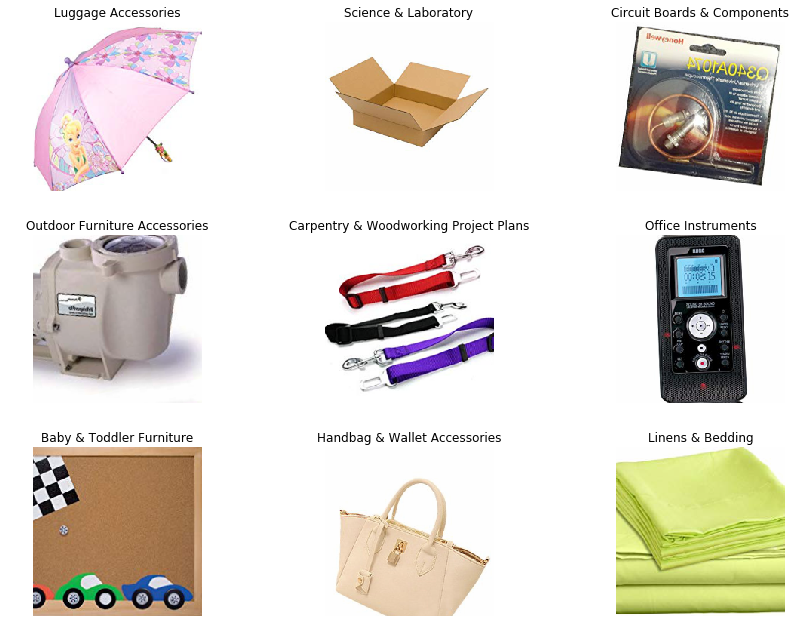

In [11]:
src.show_batch(rows=3, figsize=(12,9))

In [0]:
# # print(src.classes)
# # len(src.classes),src.c

# for c in src.classes:
#     with open("./labels.txt", "a") as f:
#         f.write(c+'\n')               

In [1]:
df2.head()

NameError: ignored

In [0]:
len(src.train_ds), len(src.valid_ds), len(src.train_ds)+len(src.valid_ds)

(14090, 3522, 17612)

In [0]:
learn = cnn_learner(src, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 23163025.49it/s]


In [0]:
gc.collect()

739

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.824286,3.172208,0.729415,04:19
1,3.207998,2.827699,0.677456,04:07
2,2.712341,2.639635,0.639693,04:07
3,2.283884,2.607947,0.636286,04:08


In [0]:
# interp_train=None; interp_valid=None; gc.collect()

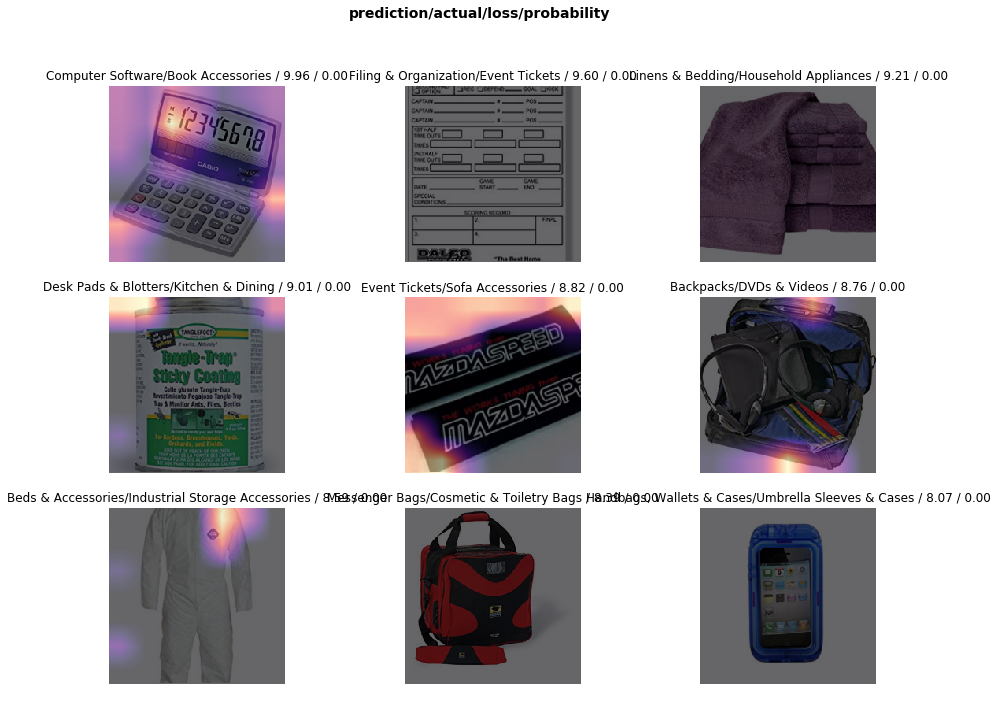

In [0]:
interp_train = ClassificationInterpretation.from_learner(learn, ds_type=1)
interp_train.plot_top_losses(9, figsize=(15,11))

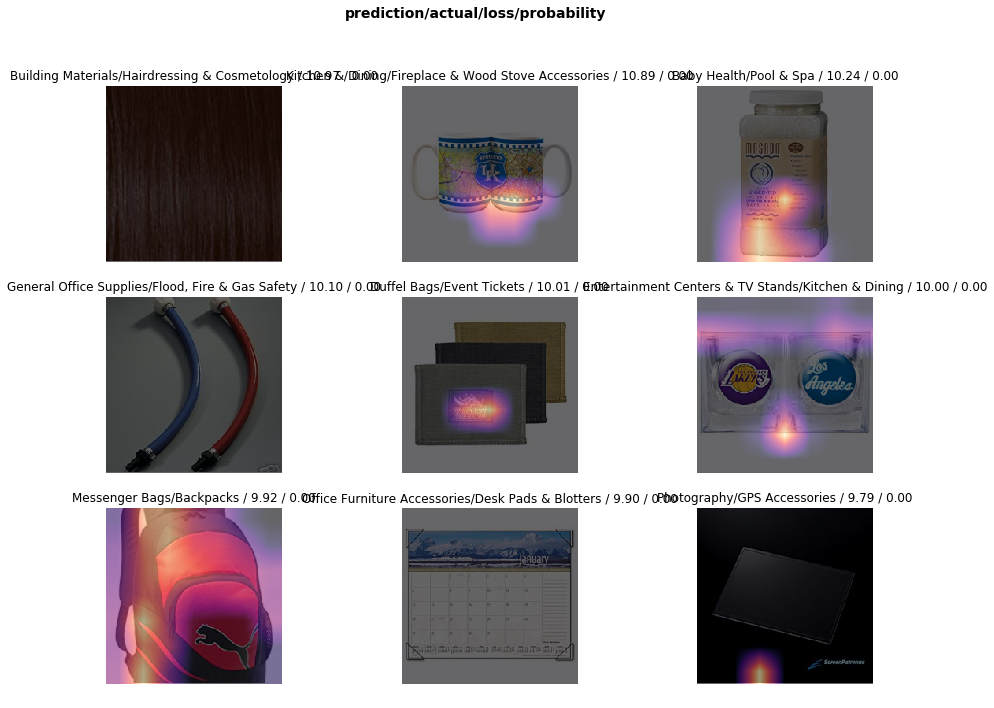

In [0]:
interp_valid = ClassificationInterpretation.from_learner(learn)
interp_valid.plot_top_losses(9, figsize=(15,11))

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.298297,2.598497,0.626917,05:05
1,2.592117,2.842712,0.671777,05:02
2,2.769571,2.940166,0.685690,04:59
3,2.616739,2.937716,0.685974,05:01


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


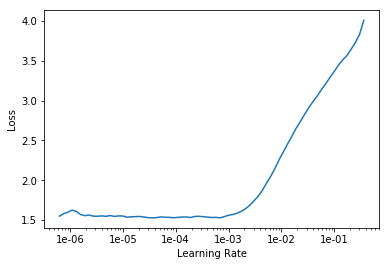

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.980276,3.444555,0.760363,05:02
1,2.363433,3.061197,0.694776,05:04
2,1.669480,2.736318,0.634299,05:03
3,1.089262,2.670550,0.622374,05:03


# Clean bad labels
Since some of the labels (not predictions) are wrong in the first place, we propose discarding the samples with wrong labels based on the losses by the model. We start with a threshold of 7 since the highest loss was around 10.

In [0]:
losses_train, idxs_train = interp_train.top_losses()
losses_valid, idxs_valid = interp_valid.top_losses()

In [0]:
THRESHOLD = 5

train_bad_labels_idx = []
valid_bad_labels_idx = []

for loss, idx in zip(losses_train, idxs_train):
    if loss > THRESHOLD:
        train_bad_labels_idx.append(idx)
        
for loss, idx in zip(losses_valid, idxs_valid):
    if loss > THRESHOLD:
        valid_bad_labels_idx.append(idx)

In [0]:
len(train_bad_labels_idx), len(valid_bad_labels_idx)

(1180, 656)

In [0]:
train = src.train_ds.x.items[:]
valid = src.valid_ds.x.items[:]

train_bad_asin = []
valid_bad_asin = []

for idx in train_bad_labels_idx:
    img_name_path = train[idx]
    asin = str(img_name_path).strip('.jpg').strip('/images')
    train_bad_asin.append(asin)
    
for idx in valid_bad_labels_idx:
    img_name_path = valid[idx]
    asin = str(img_name_path).strip('.jpg').strip('/images')
    valid_bad_asin.append(asin)    

In [0]:
len(train_bad_asin), len(valid_bad_asin)

(1180, 656)

In [0]:
print('len before:', len(df2))

df2 = df2[~df2['asin'].isin(train_bad_asin)].copy()
df2 = df2[~df2['asin'].isin(valid_bad_asin)].copy()

print('len after:', len(df2))

len before: 19448
len after: 17612


In [0]:
df2 = df2.reset_index(drop=True)

df2.to_feather('df2_clean_THRESHOLD_5_4')

In [0]:
# Push to GS
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'df2_clean_THRESHOLD_5_4'

remote_file = gs_path + file_name
!gsutil cp {file_name} gs://{remote_file} 

Copying file://df2_clean_THRESHOLD_5_4 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/607.5 KiB.                                    
